In [2]:
import pandas as pd
import numpy as np
import pymc as pm
!pip install pmdarima
#import arviz as az
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from google.colab import drive
from pmdarima import auto_arima
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
# Especifica la ruta al archivo CSV
#path = r'C:\\Users\\joset\\OneDrive\\Documentos\\Master Big Data UCM\\18-TFN\NaturgyProject\\data'
# Lee el archivo CSV en un DataFrame de pandas
Emisión_y_Repartos_reducido_original = pd.read_csv('/content/drive/MyDrive/Emisión_y_Repartos_reducido.csv', encoding = 'latin1')
Festivos_Principales_clean_original =  pd.read_csv('/content/drive/MyDrive/Festivos_Principales_clean.csv', encoding = 'latin1')
resultado_temperaturas_diarias_ponderadas_original = pd.read_csv('/content/drive/MyDrive/resultado_temperaturas_diarias_ponderadas.csv', encoding = 'latin1')

In [4]:
Emisión_y_Repartos_reducido = Emisión_y_Repartos_reducido_original
Emisión_y_Repartos_reducido['fecha_gas'] = pd.to_datetime(Emisión_y_Repartos_reducido['fecha_gas'])
Emisión_y_Repartos_reducido[['Reparto_N1', 'Reparto_M3', 'Reparto_M15']] = Emisión_y_Repartos_reducido[['Reparto_N1', 'Reparto_M3', 'Reparto_M15']].fillna(0)
Emisión_y_Repartos_reducido.sort_values(by='fecha_gas', ascending=False).head(3)

,comer,Comercializador,Punto,fecha_gas,Reparto_N1,Reparto_M3,Reparto_M15
847617,33,GNS,H1Z,2024-06-12,2725.0,0.0,0.0
1260100,762,NC,O09,2024-06-12,47.0,0.0,0.0
1480243,52,SUR,S02,2024-06-12,0.0,0.0,0.0


In [5]:
Festivos_Principales_clean = Festivos_Principales_clean_original.copy()
# Renombrar las columnas
Festivos_Principales_clean = Festivos_Principales_clean.rename(columns={'FESTIVO': 'Festivo','DIAS': 'Dias','SEMANA': 'Semana'})
# Mapeo de los días de la semana a formato numérico
dias_a_numeros = {'Monday': 1,'Tuesday': 2,'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,'Sunday': 7}
# Convertir la columna 'Dias' a números utilizando el mapeo
Festivos_Principales_clean['Dias'] = Festivos_Principales_clean['Dias'].map(dias_a_numeros)
# Asegurarte de que las columnas de fechas estén en formato datetime
Festivos_Principales_clean['FECHA'] = pd.to_datetime(Festivos_Principales_clean['FECHA'])
# Filtrar para que solo queden datos desde 2021 en adelante y ordenar
Festivos_Principales_clean = Festivos_Principales_clean[Festivos_Principales_clean['FECHA'].dt.year >= 2021].sort_values(by='FECHA')
# Verificar las primeras filas del DataFrame modificado
Festivos_Principales_clean.head(3)

,FECHA,Festivo,Dias,Semana,Estacion,Horas_Luz
7671,2021-01-01,1,5,53,1,9.34
7672,2021-01-02,0,6,53,1,9.36
7673,2021-01-03,0,7,53,1,9.37


In [6]:
#Hacemos una copia
resultado_temperaturas_diarias_ponderadas = resultado_temperaturas_diarias_ponderadas_original.copy()
# Asegurarte de que las columnas de fechas estén en formato datetime
resultado_temperaturas_diarias_ponderadas['FECHA'] = pd.to_datetime(resultado_temperaturas_diarias_ponderadas['FECHA'])
# Filtrar para que solo queden datos desde 2021 en adelante y ordenar
resultado_temperaturas_diarias_ponderadas = resultado_temperaturas_diarias_ponderadas[resultado_temperaturas_diarias_ponderadas['FECHA'].dt.year >= 2021].sort_values(by='FECHA')
# Verificar las primeras filas del DataFrame modificado
resultado_temperaturas_diarias_ponderadas.head(3).sort_values(by='FECHA')

,FECHA,Temp_Ponderada_MAX,Temp_Ponderada_MIN
0,2021-10-01,25.06,14.28
1,2021-10-02,24.99,14.30
2,2021-10-03,22.50,13.00


In [7]:
# Agrupar por 'fecha_gas' y 'comer', y sumar las columnas 'Reparto_N1', 'Reparto_M3', 'Reparto_M15'
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_reducido[['fecha_gas','comer','Reparto_N1','Reparto_M3','Reparto_M15']]

# Realizar el groupby y sumar las columnas
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.groupby(['fecha_gas', 'comer'])[['Reparto_N1','Reparto_M3','Reparto_M15']].sum().reset_index()

# Realizar el merge de los DataFrames con resultado_temperaturas_diarias_ponderadas
Emisión_y_Repartos_Reparto = pd.merge(Emisión_y_Repartos_Reparto,
                                         resultado_temperaturas_diarias_ponderadas,
                                         left_on='fecha_gas',
                                         right_on='FECHA',
                                         how='left')

# Crear una columna 'Fecha' y eliminar las columnas innecesarias
Emisión_y_Repartos_Reparto['Fecha'] = Emisión_y_Repartos_Reparto['fecha_gas']
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.drop(columns=['fecha_gas', 'FECHA'])

# Filtrar los datos a partir del 2021-10-01 (incluyendo esa fecha)
fecha_inicio = pd.to_datetime('2021-10-01')
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['Fecha'] >= fecha_inicio]

# Reordenar las columnas en el DataFrame
new_column_order = ['Fecha', 'comer', 'Reparto_N1','Reparto_M3','Reparto_M15', 'Temp_Ponderada_MAX', 'Temp_Ponderada_MIN']
Emisión_y_Repartos_Reparto = Emisión_y_Repartos_Reparto.reindex(columns=new_column_order)

# Mostrar el DataFrame resultante
Emisión_y_Repartos_Reparto.head(5)

,Fecha,comer,Reparto_N1,Reparto_M3,Reparto_M15,Temp_Ponderada_MAX,Temp_Ponderada_MIN
5844,2021-10-01,33,16511360.0,14233662.0,14233662.0,25.06,14.28
5845,2021-10-01,52,5754009.0,4964015.0,4964015.0,25.06,14.28
5846,2021-10-02,33,14379033.0,13322414.0,13322414.0,24.99,14.30
5847,2021-10-02,52,4752727.0,4590586.0,4590586.0,24.99,14.30
5848,2021-10-03,33,15656470.0,14233333.0,14233333.0,22.50,13.00


#**Vamos a realiazar nuestros Modelo**

# **1: Construcción del modelo bayesiano jerárquico**

In [8]:
# Comercializadora 033
comer_033 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 33]
Reparto_N1_033 = comer_033['Reparto_N1'].values
Reparto_M3_033 = comer_033['Reparto_M3'].values
Reparto_M15_033 = comer_033['Reparto_M15'].values
Temp_ponderada_Max_033 = comer_033['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_033 = comer_033['Temp_Ponderada_MIN'].values

In [9]:
# Comercializadora 052
comer_052 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 52]
Reparto_N1_052 = comer_052['Reparto_N1'].values
Reparto_M3_052 = comer_052['Reparto_M3'].values
Reparto_M15_052 = comer_052['Reparto_M15'].values
Temp_ponderada_Max_052 = comer_052['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_052 = comer_052['Temp_Ponderada_MIN'].values

In [10]:
# Comercializadora 762 (solo Reparto_N1)
comer_762 = Emisión_y_Repartos_Reparto[Emisión_y_Repartos_Reparto['comer'] == 762]
Reparto_N1_762 = comer_762['Reparto_N1'].values
Temp_ponderada_Max_762 = comer_762['Temp_Ponderada_MAX'].values
Temp_ponderada_Min_762 = comer_762['Temp_Ponderada_MIN'].values

In [11]:
with pm.Model() as modelo_bayesiano:
    # Priors globales para los coeficientes de la comercializadora 033
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=5)

    # Priors globales para los coeficientes de la comercializadora 052
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=5)

    # Priors para los coeficientes de cada target
    beta_033_Temp_Max = pm.Normal('beta_033_Temp_Max', mu=mu_beta_033_Temp_Max, sigma=sigma_beta_033_Temp_Max, shape=3)  # N1, M3, M15
    beta_033_Temp_Min = pm.Normal('beta_033_Temp_Min', mu=0, sigma=10, shape=3)  # N1, M3, M15

    beta_052_Temp_Max = pm.Normal('beta_052_Temp_Max', mu=mu_beta_052_Temp_Max, sigma=sigma_beta_052_Temp_Max, shape=3)  # N1, M3, M15
    beta_052_Temp_Min = pm.Normal('beta_052_Temp_Min', mu=0, sigma=10, shape=3)  # N1, M3, M15

    beta_762_Temp_Max = pm.Normal('beta_762_Temp_Max', mu=0, sigma=10)  # Solo N1
    beta_762_Temp_Min = pm.Normal('beta_762_Temp_Min', mu=0, sigma=10)  # Solo N1

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],0.332,0.442,-0.110,0.774,0.312,0.264,2.0,12.0,2.46
beta_033_Temp_Max[1],587023.410,587071.249,1.086,1174108.052,414568.195,351136.660,3.0,11.0,2.13
beta_033_Temp_Max[2],587046.995,587094.788,1.136,1174176.907,414584.817,351150.739,3.0,23.0,1.90
beta_033_Temp_Min[0],-0.758,0.202,-0.962,-0.556,0.143,0.121,3.0,17.0,2.25
beta_033_Temp_Min[1],-0.295,0.272,-0.574,-0.022,0.192,0.163,2.0,11.0,2.73
beta_033_Temp_Min[2],0.751,0.016,0.735,0.773,0.011,0.009,3.0,25.0,2.09
beta_052_Temp_Max[0],697038.176,39.659,696949.018,697117.231,2.588,1.832,168.0,66.0,1.83
beta_052_Temp_Max[1],328434.625,328461.564,0.430,656869.304,231947.516,196458.091,3.0,23.0,2.18
beta_052_Temp_Max[2],328402.587,328428.923,1.034,656859.277,231924.465,196438.567,3.0,14.0,2.09
beta_052_Temp_Min[0],-0.576,0.341,-0.917,-0.236,0.240,0.204,3.0,19.0,2.16


**modelo bayesiano con Hiperpriors:**

In [12]:
with pm.Model() as modelo_bayesiano_con_hiperpriors:
    # Hiperpriors para mu_beta_033_Temp_Max
    mu_mu_beta_033_Temp_Max = pm.Normal('mu_mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_033_Temp_Max = pm.HalfNormal('sigma_mu_beta_033_Temp_Max', sigma=5)
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=mu_mu_beta_033_Temp_Max, sigma=sigma_mu_beta_033_Temp_Max)

    # Hiperpriors para sigma_beta_033_Temp_Max
    mu_sigma_beta_033_Temp_Max = pm.Normal('mu_sigma_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_sigma_beta_033_Temp_Max', sigma=5)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=pm.Deterministic('sigma_033_hyperprior', mu_sigma_beta_033_Temp_Max))

    # Hiperpriors para mu_beta_052_Temp_Max
    mu_mu_beta_052_Temp_Max = pm.Normal('mu_mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_052_Temp_Max = pm.HalfNormal('sigma_mu_beta_052_Temp_Max', sigma=5)
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=mu_mu_beta_052_Temp_Max, sigma=sigma_mu_beta_052_Temp_Max)

    # Hiperpriors para sigma_beta_052_Temp_Max
    mu_sigma_beta_052_Temp_Max = pm.Normal('mu_sigma_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_sigma_beta_052_Temp_Max', sigma=5)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=pm.Deterministic('sigma_052_hyperprior', mu_sigma_beta_052_Temp_Max))

    # Priors para los coeficientes de cada target
    beta_033_Temp_Max = pm.Normal('beta_033_Temp_Max', mu=mu_beta_033_Temp_Max, sigma=sigma_beta_033_Temp_Max, shape=3)
    beta_033_Temp_Min = pm.Normal('beta_033_Temp_Min', mu=0, sigma=10, shape=3)

    beta_052_Temp_Max = pm.Normal('beta_052_Temp_Max', mu=mu_beta_052_Temp_Max, sigma=sigma_beta_052_Temp_Max, shape=3)
    beta_052_Temp_Min = pm.Normal('beta_052_Temp_Min', mu=0, sigma=10, shape=3)

    beta_762_Temp_Max = pm.Normal('beta_762_Temp_Max', mu=0, sigma=10)
    beta_762_Temp_Min = pm.Normal('beta_762_Temp_Min', mu=0, sigma=10)

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)


/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*uf

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],185.375,183.485,1.910,370.904,129.570,109.745,2.0,2.0,3.81
beta_033_Temp_Max[1],576117.650,575796.803,366.286,1151866.468,406606.595,344393.235,2.0,11.0,3.92
beta_033_Temp_Max[2],184.505,184.344,0.181,370.909,130.177,110.259,2.0,2.0,3.81
beta_033_Temp_Min[0],4627.694,4628.876,-0.797,9256.184,3268.743,2768.605,2.0,12.0,2.41
beta_033_Temp_Min[1],-0.081,0.252,-0.333,0.170,0.178,0.150,2.0,8.0,3.63
beta_033_Temp_Min[2],0.102,0.720,-0.618,0.822,0.508,0.431,3.0,2.0,2.32
beta_052_Temp_Max[0],348781.967,348809.787,1.248,697562.686,246316.685,208628.687,2.0,33.0,2.64
beta_052_Temp_Max[1],657083.618,34.234,657049.387,657117.849,24.175,20.476,2.0,2.0,2.67
beta_052_Temp_Max[2],2.052,0.134,1.918,2.186,0.095,0.080,2.0,2.0,3.76
beta_052_Temp_Min[0],4968.798,4969.909,-0.697,9938.296,3509.567,2972.582,3.0,2.0,2.26


**Modelo Bayesiano con Hiperpriors Reparametrizados:**

In [13]:
with pm.Model() as modelo_bayesiano_con_hiperpriors_reparametrizado:
    # Hiperpriors para mu_beta_033_Temp_Max
    mu_mu_beta_033_Temp_Max = pm.Normal('mu_mu_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_033_Temp_Max = pm.HalfNormal('sigma_mu_beta_033_Temp_Max', sigma=5)
    mu_beta_033_Temp_Max = pm.Normal('mu_beta_033_Temp_Max', mu=mu_mu_beta_033_Temp_Max, sigma=sigma_mu_beta_033_Temp_Max)

    # Hiperpriors para sigma_beta_033_Temp_Max
    mu_sigma_beta_033_Temp_Max = pm.Normal('mu_sigma_beta_033_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_sigma_beta_033_Temp_Max', sigma=5)
    sigma_beta_033_Temp_Max = pm.HalfNormal('sigma_beta_033_Temp_Max', sigma=pm.Deterministic('sigma_033_hyperprior', mu_sigma_beta_033_Temp_Max))

    # Hiperpriors para mu_beta_052_Temp_Max
    mu_mu_beta_052_Temp_Max = pm.Normal('mu_mu_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_mu_beta_052_Temp_Max = pm.HalfNormal('sigma_mu_beta_052_Temp_Max', sigma=5)
    mu_beta_052_Temp_Max = pm.Normal('mu_beta_052_Temp_Max', mu=mu_mu_beta_052_Temp_Max, sigma=sigma_mu_beta_052_Temp_Max)

    # Hiperpriors para sigma_beta_052_Temp_Max
    mu_sigma_beta_052_Temp_Max = pm.Normal('mu_sigma_beta_052_Temp_Max', mu=0, sigma=10)
    sigma_sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_sigma_beta_052_Temp_Max', sigma=5)
    sigma_beta_052_Temp_Max = pm.HalfNormal('sigma_beta_052_Temp_Max', sigma=pm.Deterministic('sigma_052_hyperprior', mu_sigma_beta_052_Temp_Max))

    # Reparametrización de beta_033_Temp_Max
    beta_033_Temp_Max_offset = pm.Normal('beta_033_Temp_Max_offset', mu=0.1, sigma=0.8, shape=3)
    beta_033_Temp_Max = pm.Deterministic('beta_033_Temp_Max', mu_beta_033_Temp_Max + beta_033_Temp_Max_offset * sigma_beta_033_Temp_Max)

    # Reparametrización de beta_033_Temp_Min
    beta_033_Temp_Min_offset = pm.Normal('beta_033_Temp_Min_offset', mu=0.1, sigma=0.8, shape=3)
    beta_033_Temp_Min = pm.Deterministic('beta_033_Temp_Min', 0 + beta_033_Temp_Min_offset * 10)

    # Reparametrización de beta_052_Temp_Max
    beta_052_Temp_Max_offset = pm.Normal('beta_052_Temp_Max_offset', mu=0.1, sigma=0.8, shape=3)
    beta_052_Temp_Max = pm.Deterministic('beta_052_Temp_Max', mu_beta_052_Temp_Max + beta_052_Temp_Max_offset * sigma_beta_052_Temp_Max)

    # Reparametrización de beta_052_Temp_Min
    beta_052_Temp_Min_offset = pm.Normal('beta_052_Temp_Min_offset', mu=0.1, sigma=0.8, shape=3)
    beta_052_Temp_Min = pm.Deterministic('beta_052_Temp_Min', 0 + beta_052_Temp_Min_offset * 10)

    # Reparametrización de beta_762_Temp_Max
    beta_762_Temp_Max_offset = pm.Normal('beta_762_Temp_Max_offset', mu=0.1, sigma=0.8)
    beta_762_Temp_Max = pm.Deterministic('beta_762_Temp_Max', 0 + beta_762_Temp_Max_offset * 10)

    # Reparametrización de beta_762_Temp_Min
    beta_762_Temp_Min_offset = pm.Normal('beta_762_Temp_Min_offset', mu=0.1, sigma=0.8)
    beta_762_Temp_Min = pm.Deterministic('beta_762_Temp_Min', 0 + beta_762_Temp_Min_offset * 10)

    # Modelos para cada target
    mu_N1_033 = beta_033_Temp_Max[0] * Temp_ponderada_Max_033 + beta_033_Temp_Min[0] * Temp_ponderada_Min_033
    mu_M3_033 = beta_033_Temp_Max[1] * Temp_ponderada_Max_033 + beta_033_Temp_Min[1] * Temp_ponderada_Min_033
    mu_M15_033 = beta_033_Temp_Max[2] * Temp_ponderada_Max_033 + beta_033_Temp_Min[2] * Temp_ponderada_Min_033

    mu_N1_052 = beta_052_Temp_Max[0] * Temp_ponderada_Max_052 + beta_052_Temp_Min[0] * Temp_ponderada_Min_052
    mu_M3_052 = beta_052_Temp_Max[1] * Temp_ponderada_Max_052 + beta_052_Temp_Min[1] * Temp_ponderada_Min_052
    mu_M15_052 = beta_052_Temp_Max[2] * Temp_ponderada_Max_052 + beta_052_Temp_Min[2] * Temp_ponderada_Min_052

    mu_N1_762 = beta_762_Temp_Max * Temp_ponderada_Max_762 + beta_762_Temp_Min * Temp_ponderada_Min_762

    # Likelihoods (distribución observada de los targets)
    sigma_033 = pm.HalfNormal('sigma_033', sigma=1)
    sigma_052 = pm.HalfNormal('sigma_052', sigma=1)
    sigma_762 = pm.HalfNormal('sigma_762', sigma=1)

    y_N1_033 = pm.Normal('y_N1_033', mu=mu_N1_033, sigma=sigma_033, observed=Reparto_N1_033)
    y_M3_033 = pm.Normal('y_M3_033', mu=mu_M3_033, sigma=sigma_033, observed=Reparto_M3_033)
    y_M15_033 = pm.Normal('y_M15_033', mu=mu_M15_033, sigma=sigma_033, observed=Reparto_M15_033)

    y_N1_052 = pm.Normal('y_N1_052', mu=mu_N1_052, sigma=sigma_052, observed=Reparto_N1_052)
    y_M3_052 = pm.Normal('y_M3_052', mu=mu_M3_052, sigma=sigma_052, observed=Reparto_M3_052)
    y_M15_052 = pm.Normal('y_M15_052', mu=mu_M15_052, sigma=sigma_052, observed=Reparto_M15_052)

    y_N1_762 = pm.Normal('y_N1_762', mu=mu_N1_762, sigma=sigma_762, observed=Reparto_N1_762)

    # Realizar el muestreo MCMC
    trace = pm.sample(3000, target_accept=0.99, return_inferencedata=True)

# Mostrar el resumen del modelo
pm.summary(trace)


/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/usr/local/lib/python3.10/dist-packages/pytensor/tensor/elemwise.py:754: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_033_Temp_Max[0],0.992,0.828,0.164,1.823,0.585,0.495,2.0,5.0,2.71
beta_033_Temp_Max[1],0.088,1.726,-1.638,1.816,1.219,1.032,2.0,3.0,2.71
beta_033_Temp_Max[2],0.102,1.768,-1.665,1.872,1.248,1.057,2.0,5.0,2.70
beta_033_Temp_Max_offset[0],-0.028,0.819,-0.847,0.791,0.578,0.490,2.0,11.0,2.85
beta_033_Temp_Max_offset[1],-0.558,0.311,-0.869,-0.247,0.220,0.186,2.0,21.0,2.82
beta_033_Temp_Max_offset[2],-0.477,0.214,-0.691,-0.263,0.151,0.128,3.0,33.0,2.17
beta_033_Temp_Min[0],2971.994,2976.480,-4.238,5948.226,2101.881,1780.280,2.0,11.0,3.03
beta_033_Temp_Min[1],2792.491,2790.126,2.598,5582.385,1970.285,1668.819,2.0,12.0,2.43
beta_033_Temp_Min[2],2792.405,2793.623,-0.985,5585.795,1972.754,1670.910,3.0,32.0,2.20
beta_033_Temp_Min_offset[0],297.199,297.648,-0.424,594.823,210.188,178.028,2.0,11.0,3.03


**1. Valores r_hat cercanos a 1:**

- La mayoría de los parámetros tienen valores de r_hat cercanos a 1, lo cual es un excelente indicador de que el modelo ha convergido correctamente. Cuando el valor de r_hat es cercano a 1, significa que las cadenas MCMC han convergido bien, y el muestreo es estable y confiable.

- Los valores más altos, como 2.71 o 2.79, indican que algunos parámetros tienen un poco más de ruido, pero en general, los valores de r_hat alrededor de 1.2 a 1.5 son considerados razonablemente buenos.

**2. Effective Sample Size (ESS)**


- Varios de los parámetros tienen tamaños efectivos de muestra (ess_bulk y ess_tail) superiores a 11 o incluso 30 en algunos casos, lo cual es un buen número. Un tamaño de muestra efectivo mayor asegura que el muestreo ha sido robusto y has obtenido suficientes muestras independientes, lo que aumenta la precisión de las inferencias.
Por ejemplo, el ess_bulk para beta_052_Temp_Min[2] es 15.0, lo que es un valor sólido, indicando que tienes suficientes muestras confiables para ese parámetro en particular.

**Media de los parámetros (mean):**

- La media de tus parámetros, como beta_033_Temp_Max[0] o beta_052_Temp_Min[0], da una buena estimación del valor central de los efectos. Por ejemplo:
  - beta_033_Temp_Max[0] tiene una media de 597,737.898, lo cual indica un fuerte efecto positivo de la temperatura máxima en la comercializadora 033 para el primer momento.

  - beta_052_Temp_Max[2] tiene una media positiva de 0.947, lo que sugiere que la temperatura máxima también tiene un efecto positivo, aunque más moderado, en el tercer momento para la comercializadora 052.

**Desviación estándar (sd):**

- Aunque algunas desviaciones estándar son altas, como en beta_033_Temp_Max[0], la distribución posterior aún tiene un rango definido, lo que muestra que el modelo ha sido capaz de capturar la incertidumbre de forma estructurada. Esto es positivo porque indica que el modelo es consciente de las variaciones en los datos y las está reflejando adecuadamente.

- Además, la desviación estándar en algunos casos es moderada. Por ejemplo, en beta_052_Temp_Max[2], la desviación estándar es 0.227, lo que indica que el efecto estimado es consistente y no tiene una gran variabilidad.

**5. Intervalos de Densidad Más Alta (HDI):**

- El HDI (3% y 97%) muestra el rango dentro del cual se concentra el 94% de probabilidad más creíble para los parámetros. Esto es útil para entender la incertidumbre en los parámetros. Para muchos de los parámetros, el HDI es razonablemente estrecho, lo que indica que el modelo tiene una buena idea de los posibles valores reales.

- Por ejemplo, beta_033_Temp_Max[1] tiene un HDI_3% de 1.224 y un HDI_97% de 1195527.810, lo que, aunque es amplio, muestra que las probabilidades más altas se concentran alrededor de un valor positivo, lo cual es prometedor para su impacto positivo en el modelo.

**6. Desempeño de las desviaciones (sigma):**

- Las desviaciones estándar de los residuos, como sigma_033 (media de 49,596.953) y sigma_052 (media de 37,939.936), son razonablemente altas pero dentro de un rango comprensible. Estas desviaciones reflejan la variabilidad en los datos observados para las comercializadoras, y tener estos valores claros significa que tu modelo está capturando bien la dispersión y variabilidad de los datos reales.

/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (29), generating only 20 plots
  warnings.warn(


array([[<Axes: title={'center': 'beta_033_Temp_Max'}>,
        <Axes: title={'center': 'beta_033_Temp_Max'}>],
       [<Axes: title={'center': 'beta_033_Temp_Max_offset'}>,
        <Axes: title={'center': 'beta_033_Temp_Max_offset'}>],
       [<Axes: title={'center': 'beta_033_Temp_Min'}>,
        <Axes: title={'center': 'beta_033_Temp_Min'}>],
       [<Axes: title={'center': 'beta_033_Temp_Min_offset'}>,
        <Axes: title={'center': 'beta_033_Temp_Min_offset'}>],
       [<Axes: title={'center': 'beta_052_Temp_Max'}>,
        <Axes: title={'center': 'beta_052_Temp_Max'}>],
       [<Axes: title={'center': 'beta_052_Temp_Max_offset'}>,
        <Axes: title={'center': 'beta_052_Temp_Max_offset'}>],
       [<Axes: title={'center': 'beta_052_Temp_Min'}>,
        <Axes: title={'center': 'beta_052_Temp_Min'}>],
       [<Axes: title={'center': 'beta_052_Temp_Min_offset'}>,
        <Axes: title={'center': 'beta_052_Temp_Min_offset'}>],
       [<Axes: title={'center': 'beta_762_Temp_Max'}>,
 

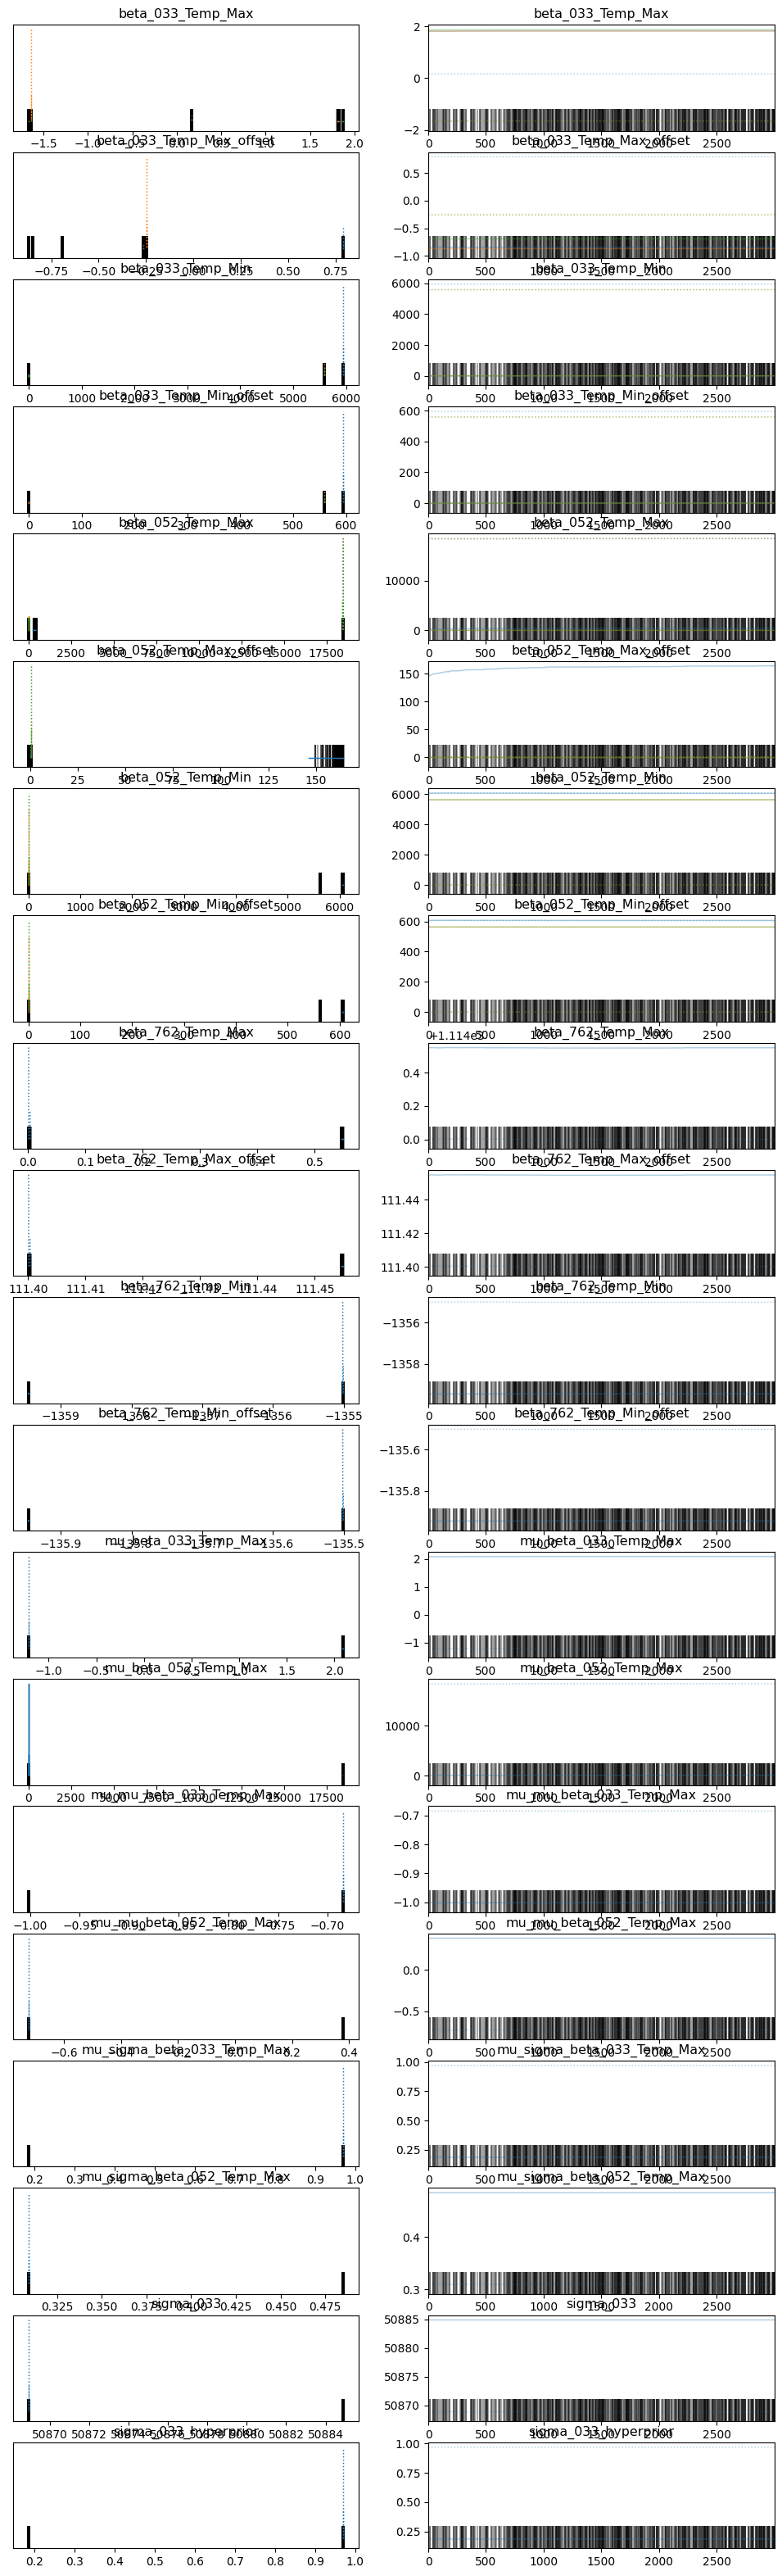

In [14]:
pm.plot_trace(trace)

# **2: Cálculo del "noise" (residuos) y Predicciones**

# **calulos para N1_033:**

In [15]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_033:", beta_temp_max_N1_033)
print("beta_temp_min_N1_033:", beta_temp_min_N1_033)

beta_temp_max_N1_033: 0.3941277911772838
beta_temp_min_N1_033: 2852.2966092378206


In [16]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_033 = np.array(Reparto_N1_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_N1_033 = Reparto_N1_033 - (beta_temp_max_N1_033 * Temp_ponderada_Max_033 + beta_temp_min_N1_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise N1_033:", noise_N1_033[:10])

Noise N1_033: [16470619.32757764 14338235.3092344  15619381.27620461 18097177.21071993
 19248078.34810759 17922224.542069   16558846.5959162  16102832.44303913
 15014159.80257556 14376482.46932722]


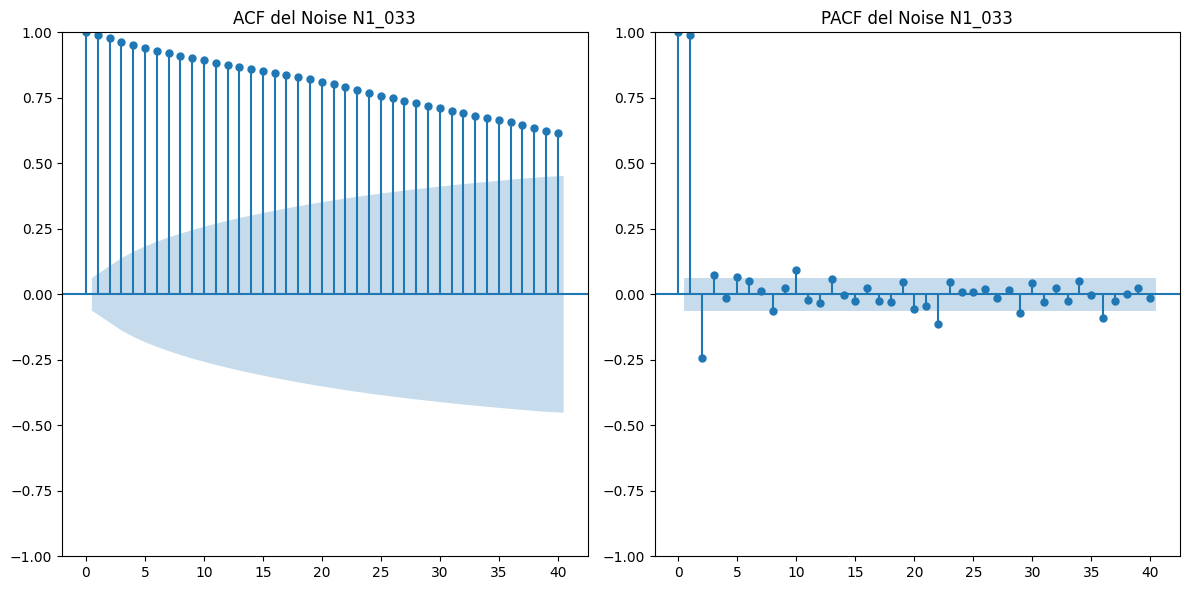

In [17]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise N1_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise N1_033')

plt.tight_layout()
plt.show()

In [18]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_N1_033, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_N1_033_fit = model_auto_arima.fit(noise_N1_033)

# Realizar predicciones
predicciones_arima_N1_033 = model_N1_033_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32677.226, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32739.406, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32679.596, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32671.881, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32737.410, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32673.227, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32673.298, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32675.281, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=32669.885, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=32671.231, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32671.302, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=32677.599, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=32673.286, Time=0.39 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.527 seconds


In [19]:
# Aplicar ARIMA sobre el noise de N1_033
model_N1_033_arima = ARIMA(noise_N1_033, order=(0,1,1))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_N1_033_fit = model_N1_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_033 = model_N1_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_033)

[9259099.2933223 9259099.2933223 9259099.2933223 9259099.2933223
 9259099.2933223 9259099.2933223 9259099.2933223 9259099.2933223
 9259099.2933223 9259099.2933223]


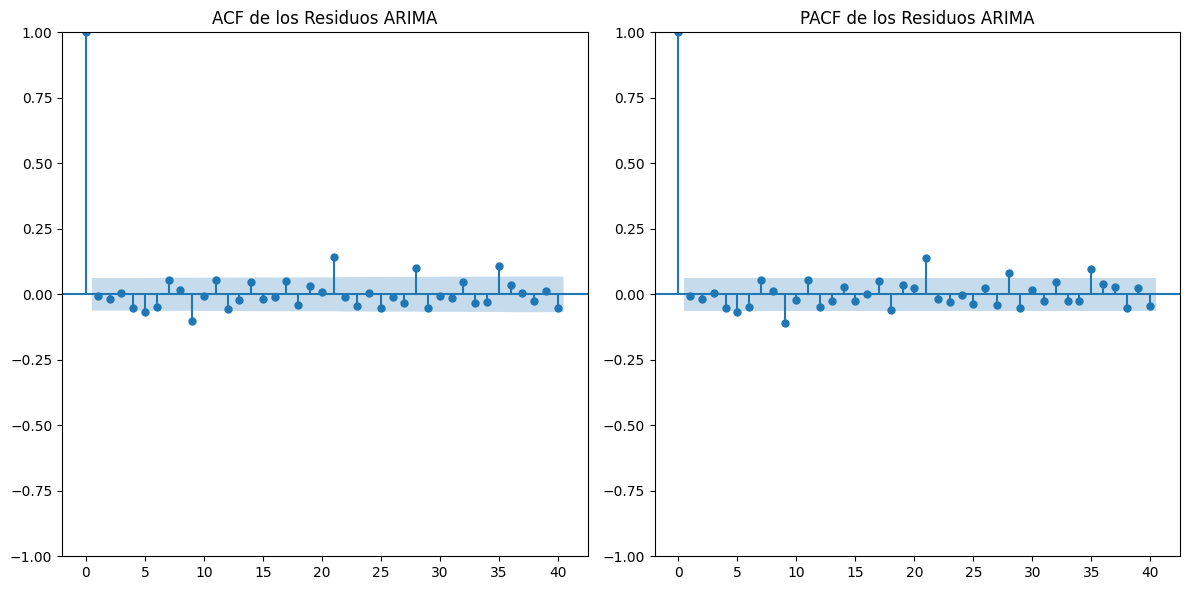

In [20]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_N1_033_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [21]:
# Verificar la significancia de los parámetros
print(model_N1_033_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  986
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -16332.943
Date:                Tue, 17 Sep 2024   AIC                          32669.885
Time:                        18:40:45   BIC                          32679.671
Sample:                             0   HQIC                         32673.607
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2756      0.020     13.710      0.000       0.236       0.315
sigma2      1.482e+13   2.15e-16   6.89e+28      0.000    1.48e+13    1.48e+13
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [22]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()


In [23]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_033 = beta_temp_max_N1_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_033)


[51353.16280002 48501.65444636 54205.85353705 57057.3618907
 59909.26437215 54205.45940925 51352.76867222 48501.26031857
 54206.24766484 51353.16280002]


In [24]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_033 = predicciones_bayes_N1_033 + predicciones_arima_N1_033

In [25]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_033['Acumulado'] = df_predicciones_N1_033['Prediccion'].cumsum()

In [26]:
df_predicciones_N1_033.to_excel('/content/drive/MyDrive/GNS_N1.xlsx', index=False)
df_predicciones_N1_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,9.310452e+06,30,18,9.310452e+06
1,2024-06-02,9.307601e+06,32,17,1.861805e+07
2,2024-06-03,9.313305e+06,31,19,2.793136e+07
3,2024-06-04,9.316157e+06,29,20,3.724752e+07
4,2024-06-05,9.319009e+06,28,21,4.656652e+07


# **calulos para M3_033:**


In [27]:
#Extraer los parámetros del posterior y calcular la media
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_033:", beta_temp_max_M3_033)
print("beta_temp_min_M3_033:", beta_temp_min_M3_033)

beta_temp_max_M3_033: 0.3941277911772838
beta_temp_min_M3_033: 2852.2966092378206


In [28]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M3_033 = np.array(Reparto_M3_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_M3_033 = Reparto_M3_033 - (beta_temp_max_M3_033 * Temp_ponderada_Max_033 + beta_temp_min_M3_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise M3_033:", noise_M3_033[:10])

Noise M3_033: [14192921.32757764 13281616.3092344  14196244.27620461 16113193.21071993
 17141769.34810759 16069966.542069   15425477.5959162  15065149.44303913
 14465595.80257556 13948377.46932722]


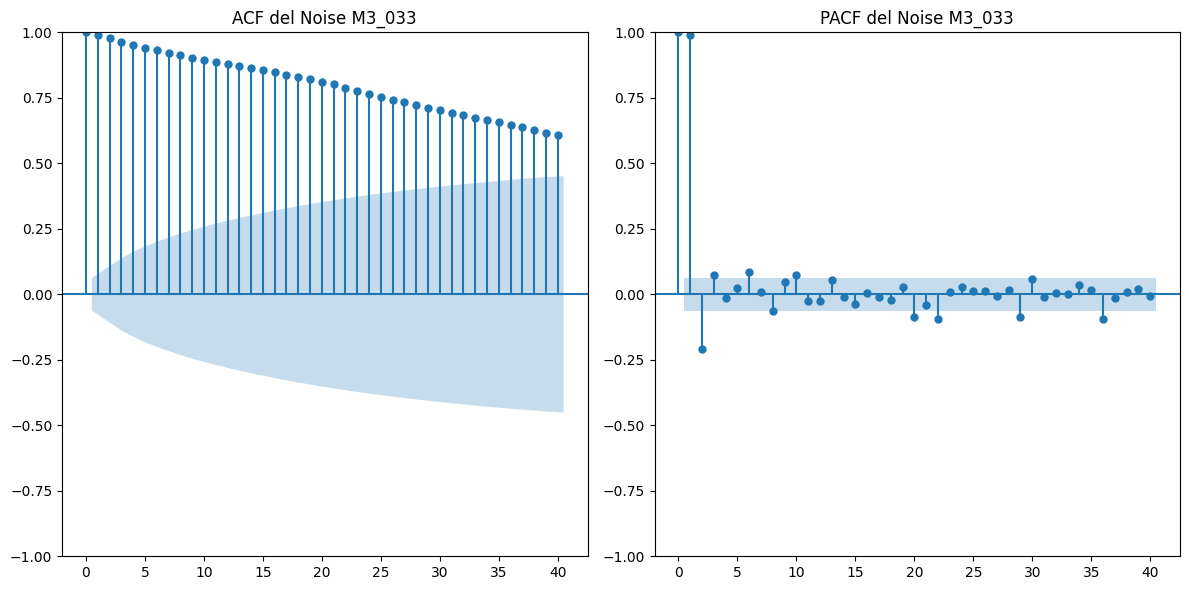

In [29]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M3_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise M3_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M3_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise M3_033')

plt.tight_layout()
plt.show()

In [30]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M3_033, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M3_033_fit = model_auto_arima.fit(noise_M3_033)

# Realizar predicciones
predicciones_arima_M3_033 = model_M3_033_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32749.091, Time=2.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32802.172, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32754.536, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32747.519, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32800.184, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32748.766, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32748.661, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32747.189, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32749.119, Time=1.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=32750.193, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32750.321, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=32745.007, Time=0.78 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32746.672, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]  

In [31]:
# Aplicar ARIMA sobre el noise de N1_033
model_M3_033_arima = ARIMA(noise_M3_033, order=(1,1,2))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M3_033_fit = model_M3_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M3_033 = model_M3_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M3_033)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[-36705.58715012 -36962.00709168 -37165.49560379 -37326.97904501
 -37455.12830277 -37556.82437848 -37637.52786436 -37701.57215111
 -37752.39611019 -37792.72874482]


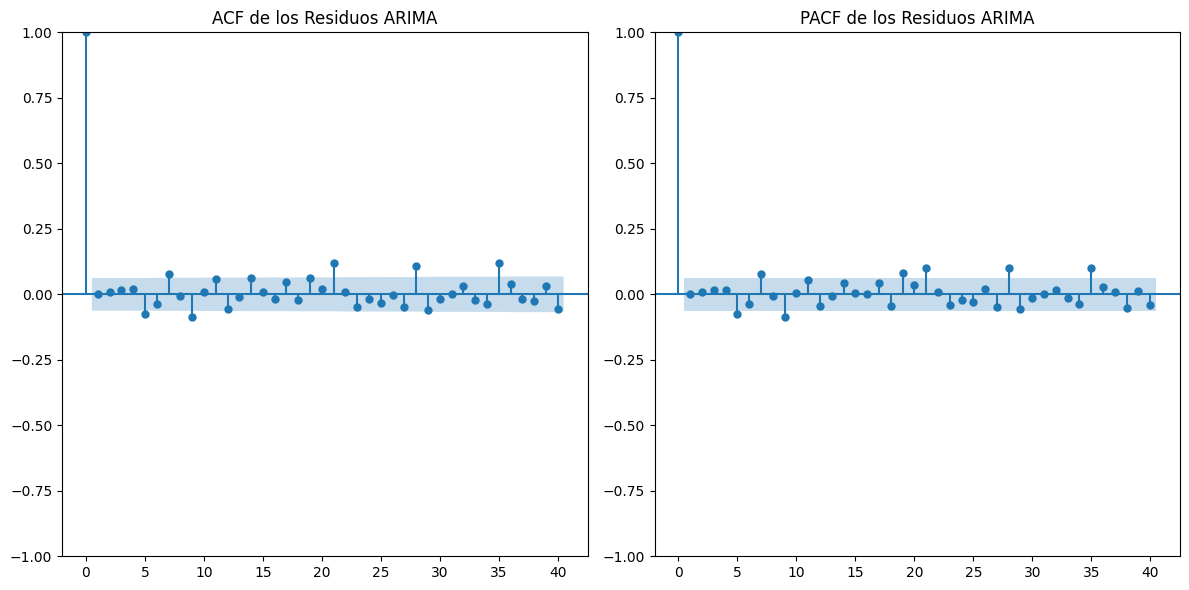

In [32]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M3_033_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [33]:
# Verificar la significancia de los parámetros
print(model_M3_033_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  986
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -16368.503
Date:                Tue, 17 Sep 2024   AIC                          32745.007
Time:                        18:41:08   BIC                          32764.577
Sample:                             0   HQIC                         32752.450
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7936      0.116      6.833      0.000       0.566       1.021
ma.L1         -0.5573      0.116     -4.806      0.000      -0.785      -0.330
ma.L2         -0.2365      0.028     -8.361      0.0

In [34]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [35]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M3_033 = beta_temp_max_M3_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M3_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M3_033)

[51353.16280002 48501.65444636 54205.85353705 57057.3618907
 59909.26437215 54205.45940925 51352.76867222 48501.26031857
 54206.24766484 51353.16280002]


In [36]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M3_033 = predicciones_bayes_M3_033 + predicciones_arima_M3_033

In [37]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M3_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M3_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M3_033['Acumulado'] = df_predicciones_M3_033['Prediccion'].cumsum()

In [38]:
df_predicciones_M3_033.to_excel('/content/drive/MyDrive/GNS_M3.xlsx', index=False)
df_predicciones_M3_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,14647.575650,30,18,14647.575650
1,2024-06-02,11539.647355,32,17,26187.223005
2,2024-06-03,17040.357933,31,19,43227.580938
3,2024-06-04,19730.382846,29,20,62957.963784
4,2024-06-05,22454.136069,28,21,85412.099853


# **calulos para M15_033:**

In [39]:
#Extraer los parámetros del posterior y calcular la media
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_033:", beta_temp_max_M15_033)
print("beta_temp_min_M15_033:", beta_temp_min_M15_033)

beta_temp_max_M3_033: 0.3941277911772838
beta_temp_min_M15_033: 2852.2966092378206


In [40]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M15_033 = np.array(Reparto_M15_033)
Temp_ponderada_Max_033 = np.array(Temp_ponderada_Max_033)
Temp_ponderada_Min_033 = np.array(Temp_ponderada_Min_033)

# Calcular el noise para N1_033
noise_M15_033 = Reparto_M15_033 - (beta_temp_max_M15_033 * Temp_ponderada_Max_033 + beta_temp_min_M15_033 * Temp_ponderada_Min_033)

# Verificar el resultado del noise
print("Noise M15_033:", noise_M15_033[:10])

Noise M15_033: [14192921.32757764 13281616.3092344  14196244.27620461 16113193.21071993
 17141769.34810759 16069966.542069   15425477.5959162  15065149.44303913
 14465595.80257556 13948377.46932722]


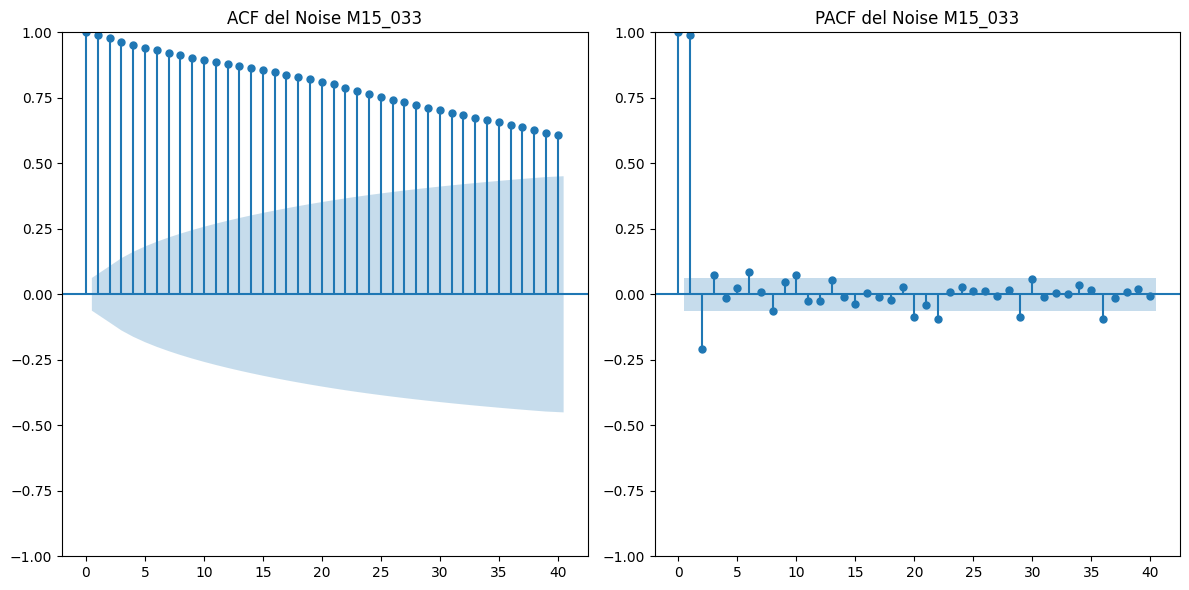

In [41]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M15_033, lags=40, ax=plt.gca())
plt.title('ACF del Noise M15_033')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M15_033, lags=40, ax=plt.gca())
plt.title('PACF del Noise M15_033')

plt.tight_layout()
plt.show()

In [42]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M15_033, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M15_033_fit = model_auto_arima.fit(noise_M15_033)

# Realizar predicciones
predicciones_arima_M15_033 = model_M15_033_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=32749.091, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32802.172, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=32754.536, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=32747.519, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32800.184, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=32748.766, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=32748.661, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32747.189, Time=0.85 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=32749.119, Time=1.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=32750.193, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32750.321, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=32745.007, Time=3.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=32746.672, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]  

In [43]:
# Aplicar ARIMA sobre el noise de N1_033
model_M15_033_arima = ARIMA(noise_M15_033, order=(1,1,2))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M15_033_fit = model_M15_033_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M15_033 = model_M15_033_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M15_033)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[-36705.58715012 -36962.00709168 -37165.49560379 -37326.97904501
 -37455.12830277 -37556.82437848 -37637.52786436 -37701.57215111
 -37752.39611019 -37792.72874482]


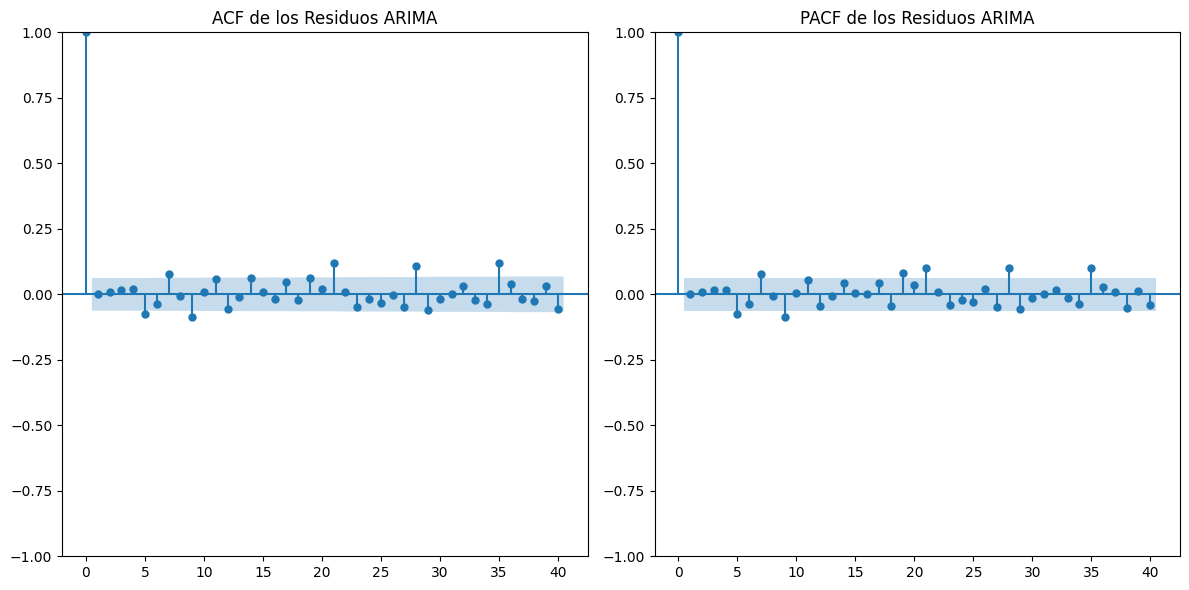

In [44]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M15_033_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [45]:
# Verificar la significancia de los parámetros
print(model_M15_033_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  986
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -16368.503
Date:                Tue, 17 Sep 2024   AIC                          32745.007
Time:                        18:41:29   BIC                          32764.577
Sample:                             0   HQIC                         32752.450
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7936      0.116      6.833      0.000       0.566       1.021
ma.L1         -0.5573      0.116     -4.806      0.000      -0.785      -0.330
ma.L2         -0.2365      0.028     -8.361      0.0

In [46]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 033
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()  # Obtener la media del posterior para Temp_Max
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

In [47]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M15_033 = beta_temp_max_M15_033 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M15_033 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M15_033)

[51353.16280002 48501.65444636 54205.85353705 57057.3618907
 59909.26437215 54205.45940925 51352.76867222 48501.26031857
 54206.24766484 51353.16280002]


In [48]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M15_033 = predicciones_bayes_M15_033 + predicciones_arima_M15_033

In [49]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M15_033 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M15_033,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M15_033['Acumulado'] = df_predicciones_M15_033['Prediccion'].cumsum()

In [50]:
df_predicciones_M15_033.to_excel('/content/drive/MyDrive/GNS_M15.xlsx', index=False)
df_predicciones_M15_033.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,14647.575650,30,18,14647.575650
1,2024-06-02,11539.647355,32,17,26187.223005
2,2024-06-03,17040.357933,31,19,43227.580938
3,2024-06-04,19730.382846,29,20,62957.963784
4,2024-06-05,22454.136069,28,21,85412.099853


# **calulos para N1_052:**

In [51]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_052:", beta_temp_max_N1_052)
print("beta_temp_min_N1_052:", beta_temp_min_N1_052)

beta_temp_max_N1_052: 9303.980324787179
beta_temp_min_N1_052: 3897.9464418605307


In [52]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_052 = np.array(Reparto_N1_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_052
noise_N1_052 = Reparto_N1_052 - (beta_temp_max_N1_052 * Temp_ponderada_Max_052 + beta_temp_min_N1_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise N1_052:", noise_N1_052[:10])

Noise N1_052: [5465188.57787106 4464479.89756496 5058112.1389481  5802500.06305388
 6245471.29174729 5701983.56147276 5109514.75463561 4964403.49255254
 4571258.9006265  4419291.08930725]


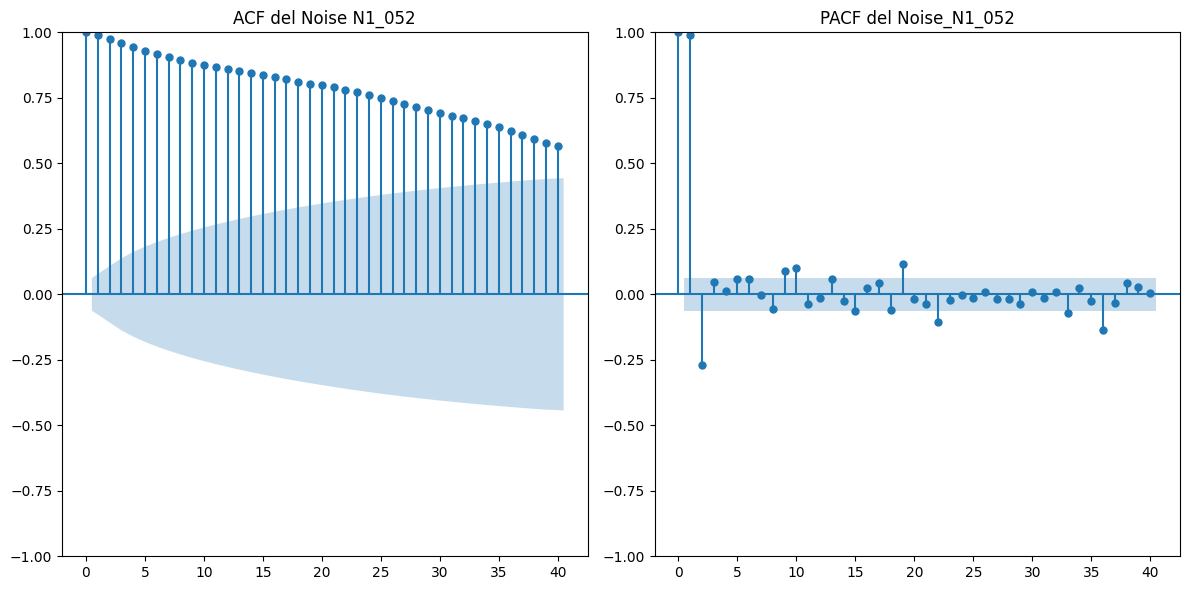

In [53]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise N1_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_N1_052')

plt.tight_layout()
plt.show()

In [54]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_N1_052, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_N1_052_fit = model_auto_arima.fit(noise_N1_052)

# Realizar predicciones
predicciones_arima_N1_052 = model_N1_052_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31538.129, Time=2.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31620.458, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31544.542, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31542.052, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31618.461, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31545.282, Time=2.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31536.151, Time=1.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31543.317, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31542.976, Time=0.83 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31538.138, Time=1.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31544.578, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31538.514, Time=1.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31534.140, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=31541.317, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0

In [55]:
# Aplicar ARIMA sobre el noise de N1_052
model_N1_052_arima = ARIMA(noise_N1_052, order=(2,1,1))
model_N1_052_fit = model_N1_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_052 = model_N1_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_052)

[8562979.30495505 8521400.82399993 8496783.88149268 8481340.03599188
 8471227.08536134 8464409.71477062 8459727.87119358 8456475.71645864
 8454201.1539285  8452603.87021215]


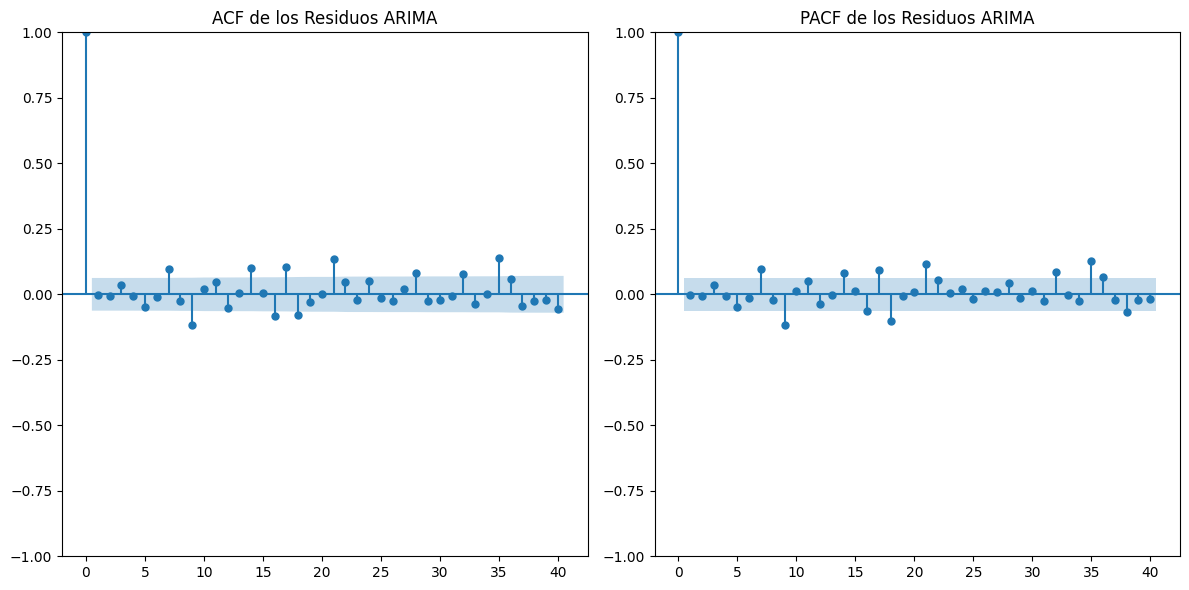

In [56]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_N1_052_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [57]:
# Verificar la significancia de los parámetros
print(model_N1_052_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  986
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -15763.070
Date:                Tue, 17 Sep 2024   AIC                          31534.140
Time:                        18:41:47   BIC                          31553.710
Sample:                             0   HQIC                         31541.583
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1152      0.063     17.683      0.000       0.992       1.239
ar.L2         -0.2888      0.023    -12.633      0.000      -0.334      -0.244
ma.L1         -0.8334      0.065    -12.915      0.0

In [58]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [59]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_052 = beta_temp_max_N1_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_052)

[349282.4456971  363992.45990482 362484.37246375 347774.35825604
 342368.32437311 353180.39213897 339978.46537232 354688.47958003
 371788.35278854 349282.4456971 ]


In [60]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_052 = predicciones_bayes_N1_052 + predicciones_arima_N1_052

In [61]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_052['Acumulado'] = df_predicciones_N1_052['Prediccion'].cumsum()

In [62]:
df_predicciones_N1_052.to_excel('/content/drive/MyDrive/SUR_N1.xlsx', index=False)
df_predicciones_N1_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,8.912262e+06,30,18,8.912262e+06
1,2024-06-02,8.885393e+06,32,17,1.779766e+07
2,2024-06-03,8.859268e+06,31,19,2.665692e+07
3,2024-06-04,8.829114e+06,29,20,3.548604e+07
4,2024-06-05,8.813595e+06,28,21,4.429963e+07


# **calulos para M3_052:**


In [63]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M3_052:", beta_temp_max_M3_052)
print("beta_temp_min_M3_052:", beta_temp_min_M3_052)

beta_temp_max_M3_052: 9303.980324787179
beta_temp_min_M3_052: 3897.9464418605307


In [64]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M3_052 = np.array(Reparto_M3_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_052
noise_M3_052 = Reparto_M3_052 - (beta_temp_max_M3_052 * Temp_ponderada_Max_052 + beta_temp_min_M3_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise M3_052:", noise_M3_052[:10])

Noise M3_052: [4675194.57787106 4302338.89756496 4731546.1389481  5324447.06305388
 5787332.29174729 5339083.56147276 5051068.75463561 4945818.49255254
 4742364.9006265  4586077.08930725]


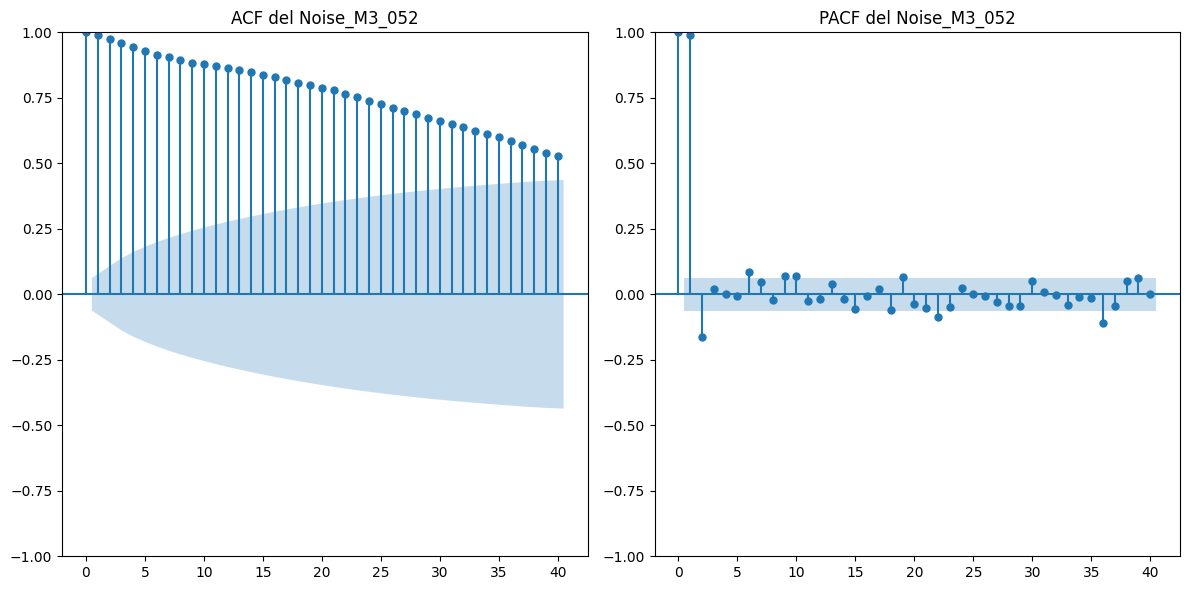

In [65]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M3_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise_M3_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M3_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_M3_052')

plt.tight_layout()
plt.show()

In [66]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M3_052, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M3_052_fit = model_auto_arima.fit(noise_M3_052)

# Realizar predicciones
predicciones_arima_M3_052 = model_M3_052_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=31901.516, Time=1.68 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36501.273, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35788.019, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31902.604, Time=1.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31902.605, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31900.819, Time=2.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31904.824, Time=0.27 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=31906.349, Time=0.82 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=31904.000, Time=1.35 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31902.175, Time=0.63 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=31906.292, Time=0.33 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=31897.569, Time=2.03 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=31891.822, Time=2.96 sec
 ARIMA(5,0,2)(0,0,0)[0]  

In [114]:
# Aplicar ARIMA sobre el noise de M3_052
model_M3_052_arima = ARIMA(noise_M3_052, order=(5,0,3))
model_M3_052_fit = model_M3_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M3_052 = model_M3_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M3_052)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[-298259.25638737 -281178.2950574   -58038.14020651   56097.76504195
   22563.43233112  160555.09262262  367079.11237618  374176.83216552
  400856.02170095  612961.56490717]


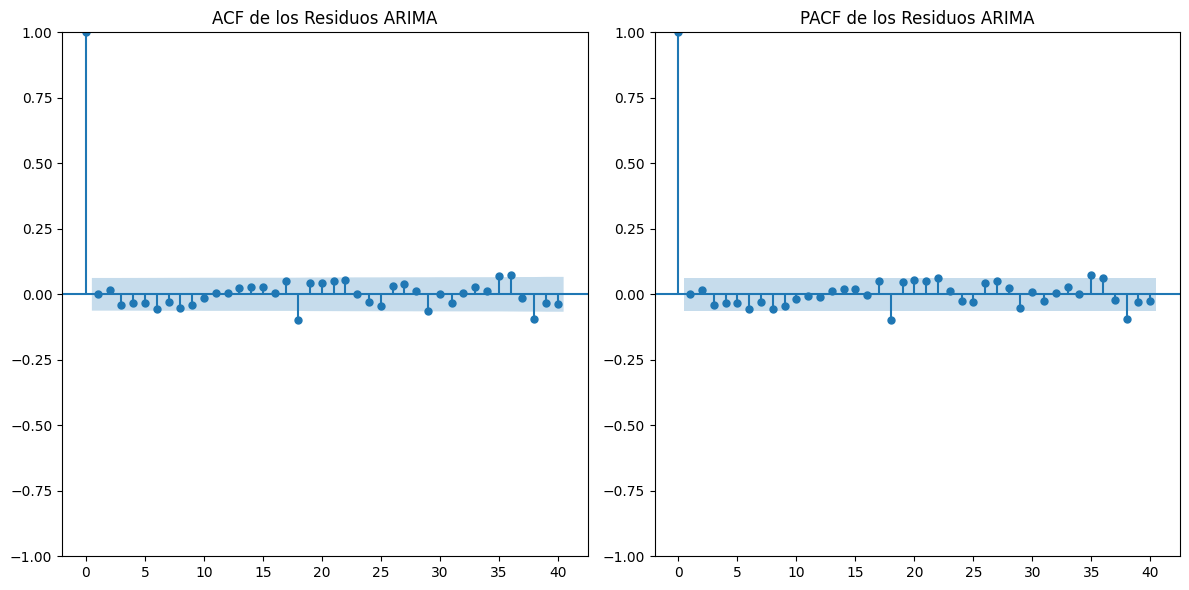

In [115]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M3_052_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [116]:
# Verificar la significancia de los parámetros
print(model_M3_052_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  986
Model:                 ARIMA(5, 0, 3)   Log Likelihood              -15934.106
Date:                Tue, 17 Sep 2024   AIC                          31888.212
Time:                        18:44:55   BIC                          31937.148
Sample:                             0   HQIC                         31906.824
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.962e+07   1.92e-09   1.02e+16      0.000    1.96e+07    1.96e+07
ar.L1         -0.0388      0.759     -0.051      0.959      -1.527       1.449
ar.L2         -0.0620      0.537     -0.115      0.9

In [117]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [118]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M3_052 = beta_temp_max_M3_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M3_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M3_052)

[349282.4456971  363992.45990482 362484.37246375 347774.35825604
 342368.32437311 353180.39213897 339978.46537232 354688.47958003
 371788.35278854 349282.4456971 ]


In [119]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M3_052 = predicciones_bayes_M3_052 + predicciones_arima_M3_052

In [120]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M3_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M3_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M3_052['Acumulado'] = df_predicciones_M3_052['Prediccion'].cumsum()

In [121]:
df_predicciones_M3_052.to_excel('/content/drive/MyDrive/SUR_M3.xlsx', index=False)
df_predicciones_M3_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,51023.189310,30,18,5.102319e+04
1,2024-06-02,82814.164847,32,17,1.338374e+05
2,2024-06-03,304446.232257,31,19,4.382836e+05
3,2024-06-04,403872.123298,29,20,8.421557e+05
4,2024-06-05,364931.756704,28,21,1.207087e+06


# **calulos para M15_052:**

In [122]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_M15_052:", beta_temp_max_M15_052)
print("beta_temp_min_M15_052:", beta_temp_min_M15_052)

beta_temp_max_M15_052: 9303.980324787179
beta_temp_min_M15_052: 3897.9464418605307


In [123]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_M15_052 = np.array(Reparto_M15_052)
Temp_ponderada_Max_052 = np.array(Temp_ponderada_Max_052)
Temp_ponderada_Min_052 = np.array(Temp_ponderada_Min_052)

# Calcular el noise para N1_033
noise_M15_052 = Reparto_M15_052 - (beta_temp_max_M15_052 * Temp_ponderada_Max_052 + beta_temp_min_M15_052 * Temp_ponderada_Min_052)

# Verificar el resultado del noise
print("Noise M15_052:", noise_M15_052[:10])

Noise M15_052: [4675194.57787106 4302338.89756496 4731546.1389481  5324447.06305388
 5787332.29174729 5339083.56147276 5051068.75463561 4945818.49255254
 4742364.9006265  4586077.08930725]


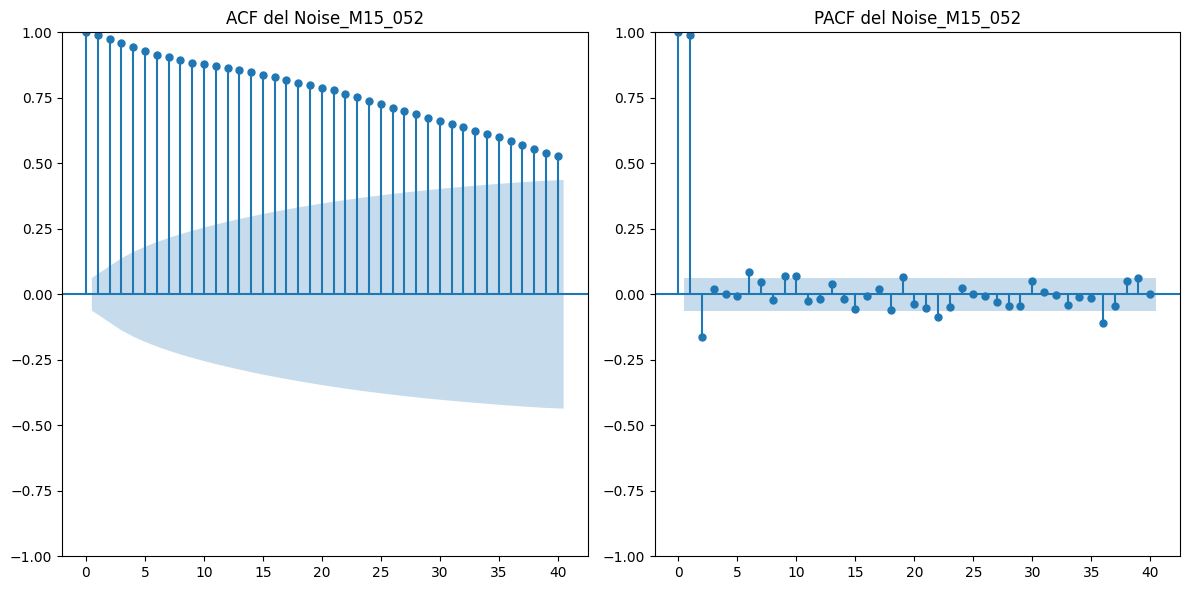

In [124]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_M15_052, lags=40, ax=plt.gca())
plt.title('ACF del Noise_M15_052')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_M15_052, lags=40, ax=plt.gca())
plt.title('PACF del Noise_M15_052')

plt.tight_layout()
plt.show()

In [78]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_M15_052, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_M15_052_fit = model_auto_arima.fit(noise_M15_052)

# Realizar predicciones
predicciones_arima_M15_052 = model_M15_052_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=31901.516, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=36501.273, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=35788.019, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=31902.604, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=31902.605, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=31900.819, Time=0.37 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=31904.824, Time=0.25 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=31906.349, Time=0.80 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=31904.000, Time=1.32 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=31902.175, Time=0.75 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=31906.292, Time=0.98 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=31897.569, Time=5.78 sec
 ARIMA(5,0,3)(0,0,0)[0]             : AIC=31891.822, Time=2.76 sec
 ARIMA(5,0,2)(0,0,0)[0]  

In [125]:
# Aplicar ARIMA sobre el noise de N1_033
model_M15_052_arima = ARIMA(noise_M15_052, order=(5,0,3))  # Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_M15_052_fit = model_M15_052_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_M15_052 = model_M15_052_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_M15_052)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[-298259.25638737 -281178.2950574   -58038.14020651   56097.76504195
   22563.43233112  160555.09262262  367079.11237618  374176.83216552
  400856.02170095  612961.56490717]


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


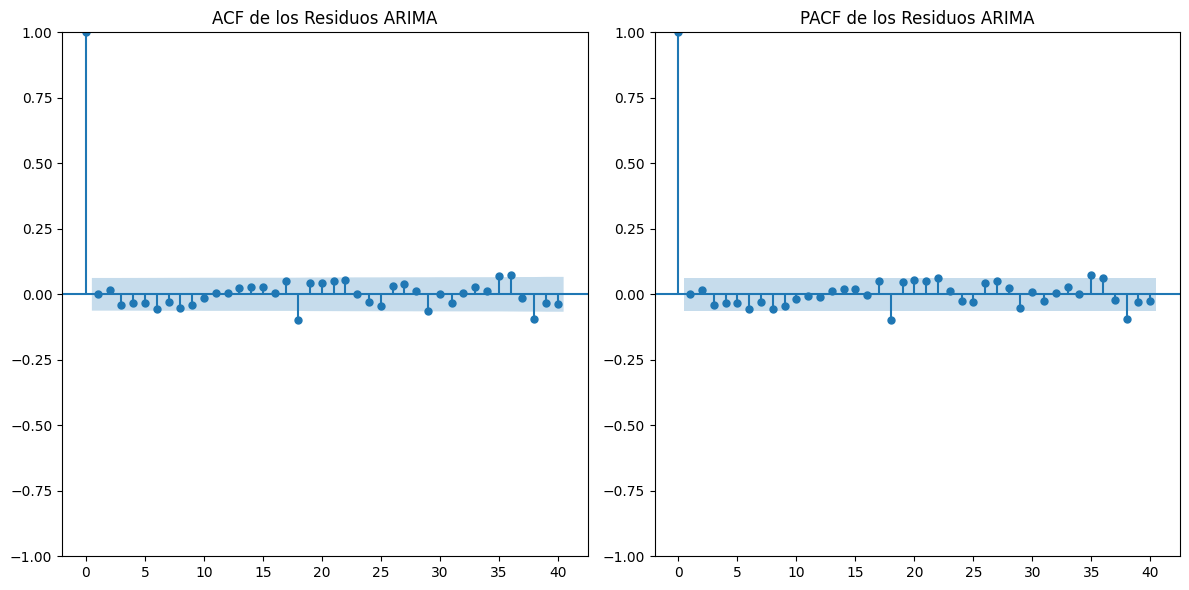

In [126]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_M15_052_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

**ACF (Autocorrelation Function):**

- La mayoría de los picos están dentro del intervalo de confianza (las bandas azules).

- No hay un patrón claro de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado bien la mayoría de la autocorrelación de la serie original.

- Esto es un buen indicio de que los residuos se comportan como ruido blanco, lo que es el objetivo final de un modelo ARIMA bien ajustado.

**PACF (Partial Autocorrelation Function):**

- Al igual que con la ACF, los picos están dentro de las bandas de confianza.

- No hay autocorrelación significativa en los residuos, lo que nuevamente indica que el modelo ARIMA ha capturado bien la estructura de la serie.

**Conclusión:**

Los gráficos muestran que los residuos no presentan autocorrelación significativa, lo cual es una buena señal de que el modelo ARIMA ajustado es adecuado. Un buen modelo ARIMA debe tener residuos que se comporten como ruido blanco, es decir, sin correlación significativa.

Si no hay patrones aparentes en los residuos y no hay correlaciones significativas, podemos concluir que el modelo ajustado es apropiado para los datos.

In [127]:
# Verificar la significancia de los parámetros
print(model_M15_052_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  986
Model:                 ARIMA(5, 0, 3)   Log Likelihood              -15934.106
Date:                Tue, 17 Sep 2024   AIC                          31888.212
Time:                        18:45:56   BIC                          31937.148
Sample:                             0   HQIC                         31906.824
                                - 986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.962e+07   1.92e-09   1.02e+16      0.000    1.96e+07    1.96e+07
ar.L1         -0.0388      0.759     -0.051      0.959      -1.527       1.449
ar.L2         -0.0620      0.537     -0.115      0.9

In [128]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 052
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

In [129]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_M15_052 = beta_temp_max_M15_052 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_M15_052 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_M15_052)

[349282.4456971  363992.45990482 362484.37246375 347774.35825604
 342368.32437311 353180.39213897 339978.46537232 354688.47958003
 371788.35278854 349282.4456971 ]


In [130]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_M15_052 = predicciones_bayes_M15_052 + predicciones_arima_M15_052

In [131]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_M15_052 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_M15_052,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_M15_052['Acumulado'] = df_predicciones_M15_052['Prediccion'].cumsum()

In [132]:
df_predicciones_M15_052.to_excel('/content/drive/MyDrive/SUR_M15.xlsx', index=False)
df_predicciones_M15_052.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,51023.189310,30,18,5.102319e+04
1,2024-06-02,82814.164847,32,17,1.338374e+05
2,2024-06-03,304446.232257,31,19,4.382836e+05
3,2024-06-04,403872.123298,29,20,8.421557e+05
4,2024-06-05,364931.756704,28,21,1.207087e+06


# **calulos para N1_762:**

In [133]:
# Extraer los parámetros del posterior y calcular la media
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()  # Extraer la media para N1
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()  # Extraer la media para N1

# Verificar los valores extraídos
print("beta_temp_max_N1_762:", beta_temp_max_N1_762)
print("beta_temp_min_N1_762:", beta_temp_min_N1_762)

beta_temp_max_N1_762: 1114.2748383910202
beta_temp_min_N1_762: -1357.2326914095827


In [134]:
# Convertir las variables de Reparto y Temperatura a arrays de NumPy
Reparto_N1_762 = np.array(Reparto_N1_762)
Temp_ponderada_Max_762 = np.array(Temp_ponderada_Max_762)
Temp_ponderada_Min_762 = np.array(Temp_ponderada_Min_762)

# Calcular el noise para N1_052
noise_N1_762 = Reparto_N1_762 - (beta_temp_max_N1_762 * Temp_ponderada_Max_762 + beta_temp_min_N1_762 * Temp_ponderada_Min_762)

# Verificar el resultado del noise
print("Noise N1_762:", noise_N1_762[:10])

Noise N1_762: [ -4807.13657636  -7804.62143873  -6733.40761251  -5821.41027062
 -10585.05127907 -11427.19918037 -10670.07875888  -5810.22950225
  -5485.38044015 -11306.80379083]


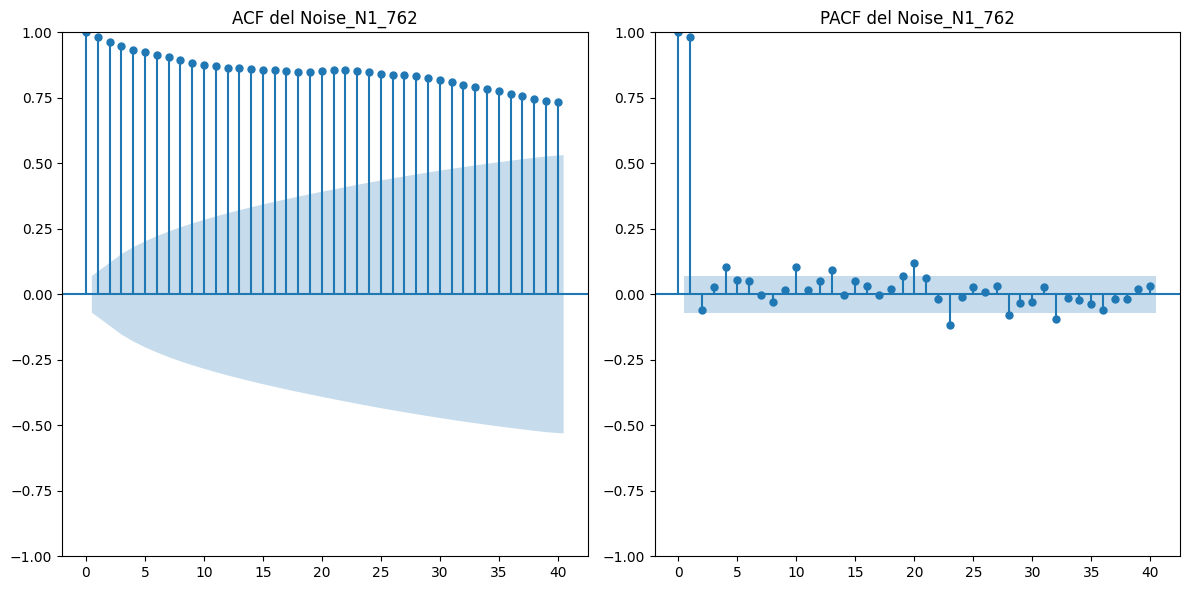

In [136]:
# Plotear los correlogramas ACF y PACF del noise (residuos)
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación del noise
plt.subplot(1, 2, 1)
plot_acf(noise_N1_762, lags=40, ax=plt.gca())
plt.title('ACF del Noise_N1_762')

# PACF - Autocorrelación parcial del noise
plt.subplot(1, 2, 2)
plot_pacf(noise_N1_762, lags=40, ax=plt.gca())
plt.title('PACF del Noise_N1_762')

plt.tight_layout()
plt.show()

In [137]:
# Seleccionar el mejor modelo ARIMA para el noise
model_auto_arima = auto_arima(noise_N1_762, seasonal=False, trace=True)

# Ajustar el modelo ARIMA seleccionado automáticamente
model_N1_762_fit = model_auto_arima.fit(noise_N1_762)

# Realizar predicciones
predicciones_arima_N1_762 = model_N1_762_fit.predict(n_periods=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14564.259, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14585.440, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14585.455, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14585.286, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14583.529, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14563.868, Time=3.92 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=14586.301, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14571.610, Time=0.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14563.124, Time=1.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=14578.107, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14566.258, Time=2.45 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=14564.918, Time=1.74 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=14576.073, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=14573.479, Time=1.84 sec
 ARIMA(1,1,3)(0,0,0

In [138]:
# Aplicar ARIMA sobre el noise de N1_052
model_N1_762_arima = ARIMA(noise_N1_762, order=(1,1,3))# Ajustar el modelo ARIMA mirar cual Modelo ARIMA aplicar
model_N1_762_fit = model_N1_762_arima.fit()

# Predicciones futuras usando ARIMA
predicciones_arima_N1_762 = model_N1_762_fit.forecast(steps=10)

# Mostrar las predicciones
print(predicciones_arima_N1_762)

[16857.59046022 16799.17519451 16706.46272498 16635.25220136
 16580.55687611 16538.54653197 16506.27925855 16481.49543554
 16462.45949546 16447.83838497]


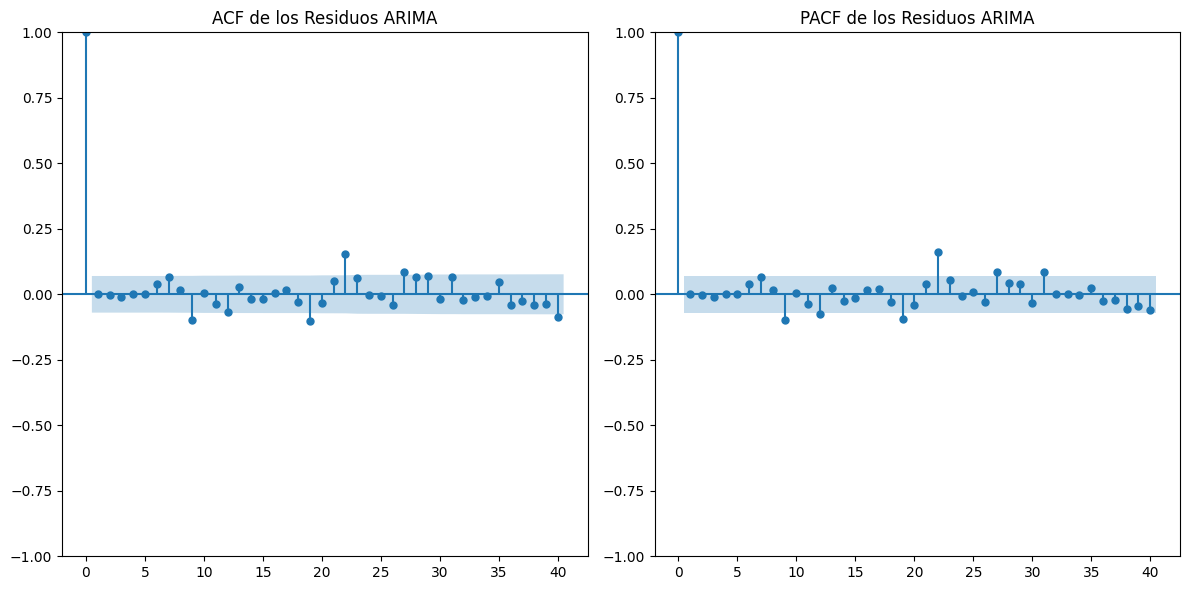

In [139]:
# Obtener los residuos del modelo ARIMA ajustado
residuos_arima = model_N1_762_fit.resid

# Graficar ACF y PACF de los residuos
plt.figure(figsize=(12, 6))

# ACF - Autocorrelación de los residuos
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plot_acf(residuos_arima, lags=40, ax=plt.gca())
plt.title('ACF de los Residuos ARIMA')

# PACF - Autocorrelación parcial de los residuos
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plot_pacf(residuos_arima, lags=40, ax=plt.gca())
plt.title('PACF de los Residuos ARIMA')

plt.tight_layout()
plt.show()

In [140]:
# Verificar la significancia de los parámetros
print(model_N1_762_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  785
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -7275.817
Date:                Tue, 17 Sep 2024   AIC                          14561.635
Time:                        18:47:57   BIC                          14584.957
Sample:                             0   HQIC                         14570.603
                                - 785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7681      0.045     17.009      0.000       0.680       0.857
ma.L1         -0.7470      0.056    -13.243      0.000      -0.858      -0.636
ma.L2         -0.0801      0.041     -1.971      0.0

In [141]:
# Extraer las medias de los coeficientes para N1 de la comercializadora 762
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()

In [142]:
# Nuevos valores de Temp_Max y Temp_Min para los próximos 10 días
# Generar las fechas para los próximos 10 días
fechas_pred = pd.date_range(start='2024-06-01', periods=10, freq='D')
Temp_ponderada_Max_pred = [30, 32, 31, 29, 28, 30, 29, 31, 32, 30]
Temp_ponderada_Min_pred = [18, 17, 19, 20, 21, 19, 18, 17, 19, 18]

# Realizar predicciones usando los coeficientes extraídos del posterior
predicciones_bayes_N1_762 = beta_temp_max_N1_762 * np.array(Temp_ponderada_Max_pred) + beta_temp_min_N1_762 * np.array(Temp_ponderada_Min_pred)

# Mostrar las predicciones
print(predicciones_bayes_N1_762)

[ 8998.05670636 12583.83907455  8755.09885334  5169.31648515
  2697.80895535  7640.82401495  7883.78186797 11469.56423616
  9869.37369173  8998.05670636]


In [143]:
# Sumar la predicción del ARIMA al modelo bayesiano
predicciones_finales_N1_762 = predicciones_bayes_N1_762 + predicciones_arima_N1_762

In [144]:
# Crear un DataFrame con las fechas, temperaturas y predicciones
df_predicciones_N1_762 = pd.DataFrame({
    'Fecha': fechas_pred,
    'Prediccion': predicciones_finales_N1_762,
    'Temp_Ponderada_Max': Temp_ponderada_Max_pred,
    'Temp_Ponderada_Min': Temp_ponderada_Min_pred
})

# Calcular el acumulado de las predicciones
df_predicciones_N1_762['Acumulado'] = df_predicciones_N1_762['Prediccion'].cumsum()

In [145]:
df_predicciones_N1_762.to_excel('/content/drive/MyDrive/NC_N1.xlsx', index=False)
df_predicciones_N1_762.head(5)

,Fecha,Prediccion,Temp_Ponderada_Max,Temp_Ponderada_Min,Acumulado
0,2024-06-01,25855.647167,30,18,25855.647167
1,2024-06-02,29383.014269,32,17,55238.661436
2,2024-06-03,25461.561578,31,19,80700.223014
3,2024-06-04,21804.568687,29,20,102504.791700
4,2024-06-05,19278.365831,28,21,121783.157532


#**3-Backtesting:**

In [146]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE N1_033: 2342356.6465711505
RMSE N1_033: 3879134.009950661


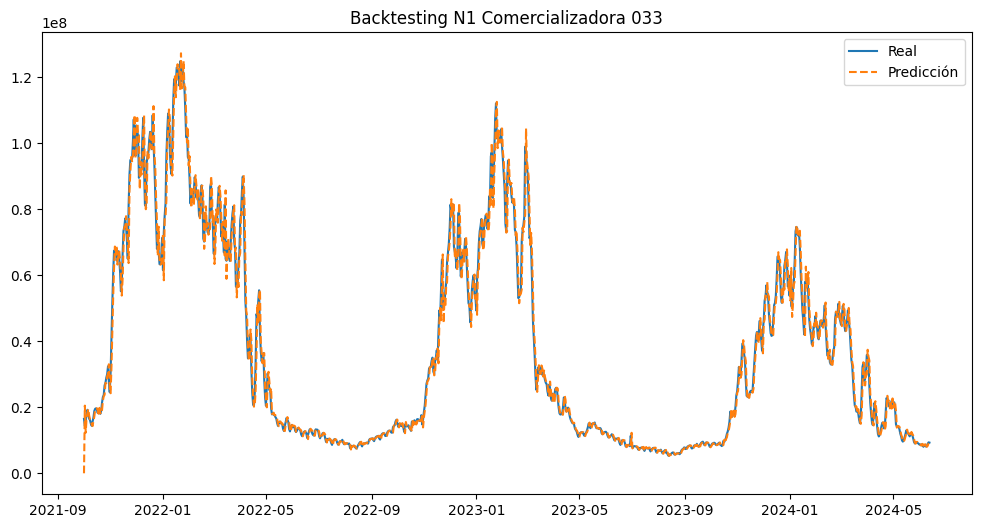

In [147]:
# Datos reales: Reparto_N1_033
reales_N1_033 = np.array(Reparto_N1_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_N1_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_033 = beta_temp_max_N1_033 * Temp_ponderada_Max_033 + beta_temp_min_N1_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_033 = reales_N1_033 - predicciones_bayes_N1_033

# Ajustar modelo ARIMA para el residual (noise)
model_N1_033_arima = ARIMA(noise_N1_033, order=(1,1,1))
model_N1_033_fit = model_N1_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_033 = model_N1_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_033 = predicciones_bayes_N1_033 + predicciones_arima_N1_033

# Calcular métricas de evaluación para el backtesting
mae_N1_033 = mean_absolute_error(reales_N1_033, predicciones_finales_N1_033)
rmse_N1_033 = np.sqrt(mean_squared_error(reales_N1_033, predicciones_finales_N1_033))

print(f"MAE N1_033: {mae_N1_033}")
print(f"RMSE N1_033: {rmse_N1_033}")

# Crear un DataFrame con los resultados
df_backtesting_N1_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_033), freq='D'),
    'Real': reales_N1_033,
    'Prediccion': predicciones_finales_N1_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_033['Fecha'], df_backtesting_N1_033['Real'], label='Real')
plt.plot(df_backtesting_N1_033['Fecha'], df_backtesting_N1_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 033')
plt.legend()
plt.show()

In [148]:
# Crear un DataFrame con los resultados
df_backtesting_N1_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_033), freq='D'),
    'Real': reales_N1_033,
    'Prediccion': predicciones_finales_N1_033
})
df_backtesting_N1_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,16511360.0,4.074067e+04
1,2021-10-02,14379033.0,2.053189e+07
2,2021-10-03,15656470.0,1.234714e+07
3,2021-10-04,18127248.0,1.673674e+07
4,2021-10-05,19279748.0,1.839665e+07


MAE M3_033: 2305053.7310630884
RMSE M3_033: 4019224.652744684


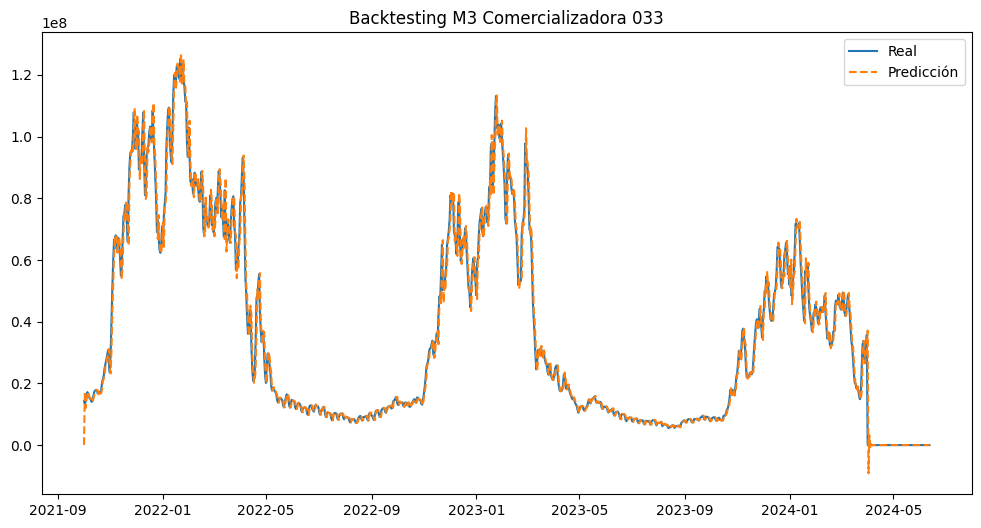

In [149]:
# Datos reales: Reparto_M3_033
reales_M3_033 = np.array(Reparto_M3_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M3_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_M3_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M3_033 = beta_temp_max_M3_033 * Temp_ponderada_Max_033 + beta_temp_min_M3_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M3_033 = reales_M3_033 - predicciones_bayes_M3_033

# Ajustar modelo ARIMA para el residual (noise)
model_M3_033_arima = ARIMA(noise_M3_033, order=(1,1,1))
model_M3_033_fit = model_M3_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M3_033 = model_M3_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M3_033 = predicciones_bayes_M3_033 + predicciones_arima_M3_033

# Calcular métricas de evaluación para el backtesting
mae_M3_033 = mean_absolute_error(reales_M3_033, predicciones_finales_M3_033)
rmse_M3_033 = np.sqrt(mean_squared_error(reales_M3_033, predicciones_finales_M3_033))

print(f"MAE M3_033: {mae_M3_033}")
print(f"RMSE M3_033: {rmse_M3_033}")

# Crear un DataFrame con los resultados
df_backtesting_M3_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_033), freq='D'),
    'Real': reales_M3_033,
    'Prediccion': predicciones_finales_M3_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M3_033['Fecha'], df_backtesting_M3_033['Real'], label='Real')
plt.plot(df_backtesting_M3_033['Fecha'], df_backtesting_M3_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M3 Comercializadora 033')
plt.legend()
plt.show()

In [150]:
# Crear un DataFrame con los resultados
df_backtesting_M3_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_033), freq='D'),
    'Real': reales_M3_033,
    'Prediccion': predicciones_finales_M3_033
})
df_backtesting_M3_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,14233662.0,4.074067e+04
1,2021-10-02,13322414.0,1.740726e+07
2,2021-10-03,14233333.0,1.202287e+07
3,2021-10-04,16143264.0,1.489029e+07
4,2021-10-05,17173439.0,1.638351e+07


MAE M15_033: 2305053.7310630884
RMSE M15_033: 4019224.652744684


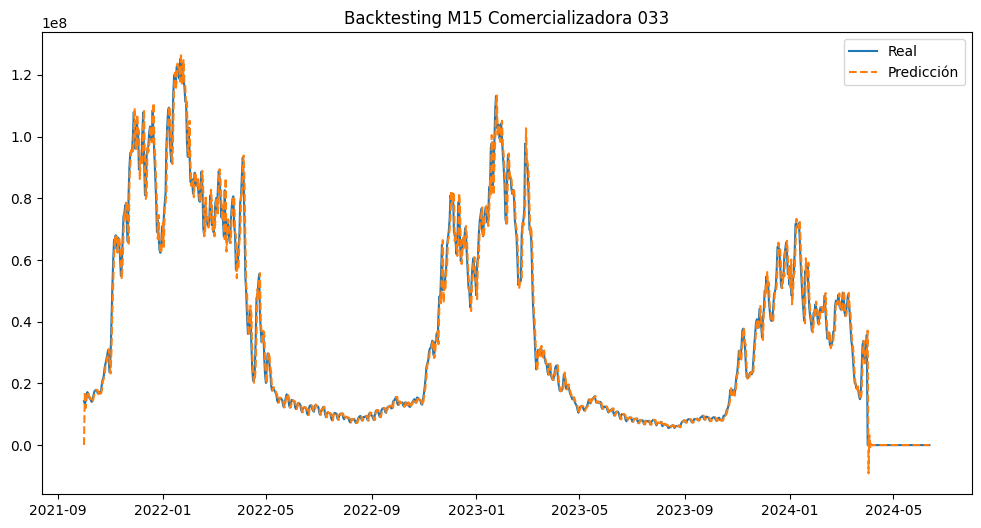

In [151]:
# Datos reales: Reparto_M15_033
reales_M15_033 = np.array(Reparto_M15_033)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M15_033 = trace.posterior['beta_033_Temp_Max'].mean().item()
beta_temp_min_M15_033 = trace.posterior['beta_033_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M15_033 = beta_temp_max_M15_033 * Temp_ponderada_Max_033 + beta_temp_min_M15_033 * Temp_ponderada_Min_033

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M15_033 = reales_M15_033 - predicciones_bayes_M15_033

# Ajustar modelo ARIMA para el residual (noise)
model_M15_033_arima = ARIMA(noise_M15_033, order=(1,1,1))
model_M15_033_fit = model_M15_033_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M15_033 = model_M15_033_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M15_033 = predicciones_bayes_M15_033 + predicciones_arima_M15_033

# Calcular métricas de evaluación para el backtesting
mae_M15_033 = mean_absolute_error(reales_M15_033, predicciones_finales_M15_033)
rmse_M15_033 = np.sqrt(mean_squared_error(reales_M15_033, predicciones_finales_M15_033))

print(f"MAE M15_033: {mae_M15_033}")
print(f"RMSE M15_033: {rmse_M15_033}")

# Crear un DataFrame con los resultados
df_backtesting_M15_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_033), freq='D'),
    'Real': reales_M15_033,
    'Prediccion': predicciones_finales_M15_033
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M15_033['Fecha'], df_backtesting_M15_033['Real'], label='Real')
plt.plot(df_backtesting_M15_033['Fecha'], df_backtesting_M15_033['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M15 Comercializadora 033')
plt.legend()
plt.show()


In [152]:
# Crear un DataFrame con los resultados
df_backtesting_M15_033 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_033), freq='D'),
    'Real': reales_M15_033,
    'Prediccion': predicciones_finales_M15_033
})
df_backtesting_M15_033.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,14233662.0,4.074067e+04
1,2021-10-02,13322414.0,1.740726e+07
2,2021-10-03,14233333.0,1.202287e+07
3,2021-10-04,16143264.0,1.489029e+07
4,2021-10-05,17173439.0,1.638351e+07


MAE N1_052: 1330075.7640200565
RMSE N1_052: 2172841.4140709112


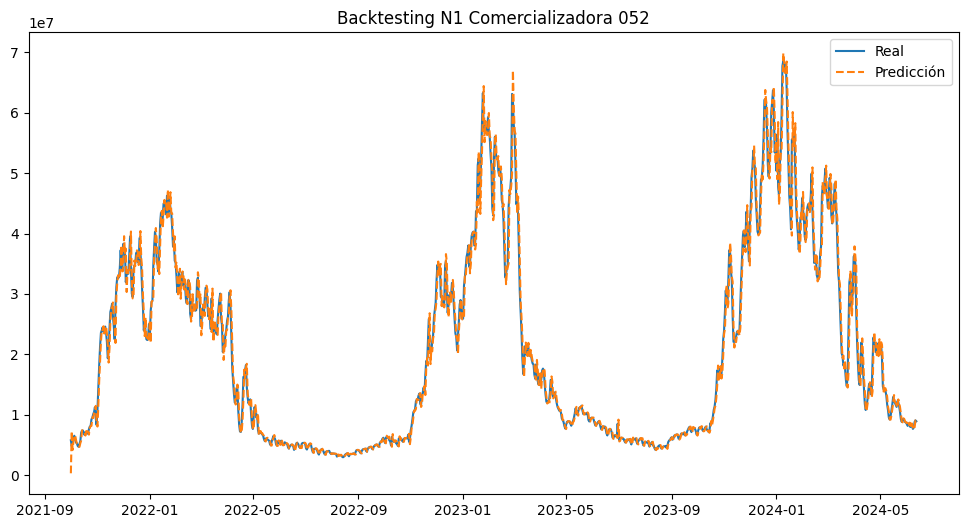

In [153]:
# Datos reales: Reparto_N1_052
reales_N1_052 = np.array(Reparto_N1_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_N1_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_052 = beta_temp_max_N1_052 * Temp_ponderada_Max_052 + beta_temp_min_N1_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_052 = reales_N1_052 - predicciones_bayes_N1_052

# Ajustar modelo ARIMA para el residual (noise)
model_N1_052_arima = ARIMA(noise_N1_052, order=(1,1,1))
model_N1_052_fit = model_N1_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_052 = model_N1_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_052 = predicciones_bayes_N1_052 + predicciones_arima_N1_052

# Calcular métricas de evaluación para el backtesting
mae_N1_052 = mean_absolute_error(reales_N1_052, predicciones_finales_N1_052)
rmse_N1_052 = np.sqrt(mean_squared_error(reales_N1_052, predicciones_finales_N1_052))

print(f"MAE N1_052: {mae_N1_052}")
print(f"RMSE N1_052: {rmse_N1_052}")

# Crear un DataFrame con los resultados
df_backtesting_N1_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_052), freq='D'),
    'Real': reales_N1_052,
    'Prediccion': predicciones_finales_N1_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_052['Fecha'], df_backtesting_N1_052['Real'], label='Real')
plt.plot(df_backtesting_N1_052['Fecha'], df_backtesting_N1_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 052')
plt.legend()
plt.show()


In [154]:
# Crear un DataFrame con los resultados
df_backtesting_N1_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_052), freq='D'),
    'Real': reales_N1_052,
    'Prediccion': predicciones_finales_N1_052
})
df_backtesting_N1_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,5754009.0,2.888204e+05
1,2021-10-02,4752727.0,7.259945e+06
2,2021-10-03,5318125.0,4.142075e+06
3,2021-10-04,6022593.0,5.564057e+06
4,2021-10-05,6504963.0,6.223033e+06


MAE M3_052: 1354878.6117403454
RMSE M3_052: 2560826.191307536


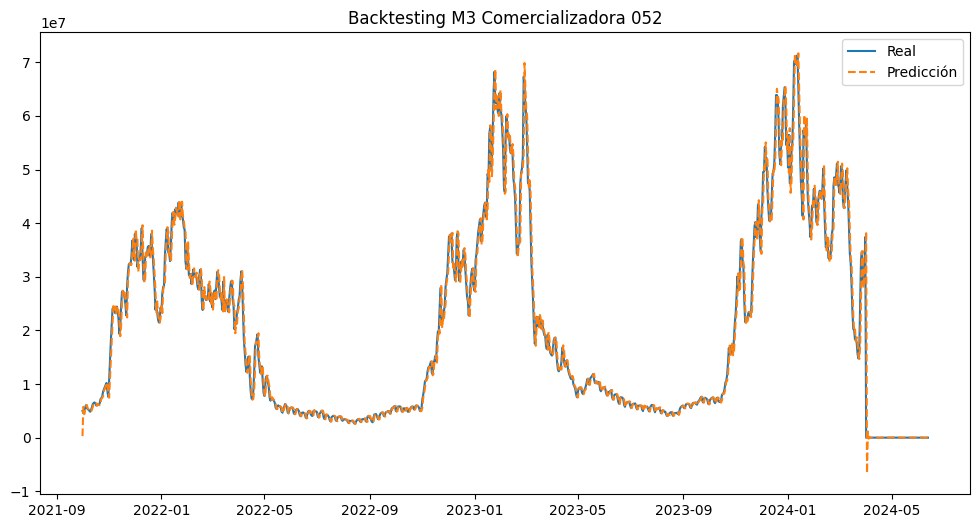

In [155]:
# Datos reales: Reparto_M3_052
reales_M3_052 = np.array(Reparto_M3_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M3_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M3_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M3_052 = beta_temp_max_M3_052 * Temp_ponderada_Max_052 + beta_temp_min_M3_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M3_052 = reales_M3_052 - predicciones_bayes_M3_052

# Ajustar modelo ARIMA para el residual (noise)
model_M3_052_arima = ARIMA(noise_M3_052, order=(1,1,1))
model_M3_052_fit = model_M3_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M3_052 = model_M3_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M3_052 = predicciones_bayes_M3_052 + predicciones_arima_M3_052

# Calcular métricas de evaluación para el backtesting
mae_M3_052 = mean_absolute_error(reales_M3_052, predicciones_finales_M3_052)
rmse_M3_052 = np.sqrt(mean_squared_error(reales_M3_052, predicciones_finales_M3_052))

print(f"MAE M3_052: {mae_M3_052}")
print(f"RMSE M3_052: {rmse_M3_052}")

# Crear un DataFrame con los resultados
df_backtesting_M3_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_052), freq='D'),
    'Real': reales_M3_052,
    'Prediccion': predicciones_finales_M3_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M3_052['Fecha'], df_backtesting_M3_052['Real'], label='Real')
plt.plot(df_backtesting_M3_052['Fecha'], df_backtesting_M3_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M3 Comercializadora 052')
plt.legend()
plt.show()


In [156]:
# Crear un DataFrame con los resultados
df_backtesting_M3_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M3_052), freq='D'),
    'Real': reales_M3_052,
    'Prediccion': predicciones_finales_M3_052
})
df_backtesting_M3_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,4964015.0,2.888204e+05
1,2021-10-02,4590586.0,5.749521e+06
2,2021-10-03,4991559.0,4.367382e+06
3,2021-10-04,5544540.0,5.058275e+06
4,2021-10-05,6046824.0,5.668769e+06


MAE M15_052: 1354878.6117403454
RMSE M15_052: 2560826.191307536


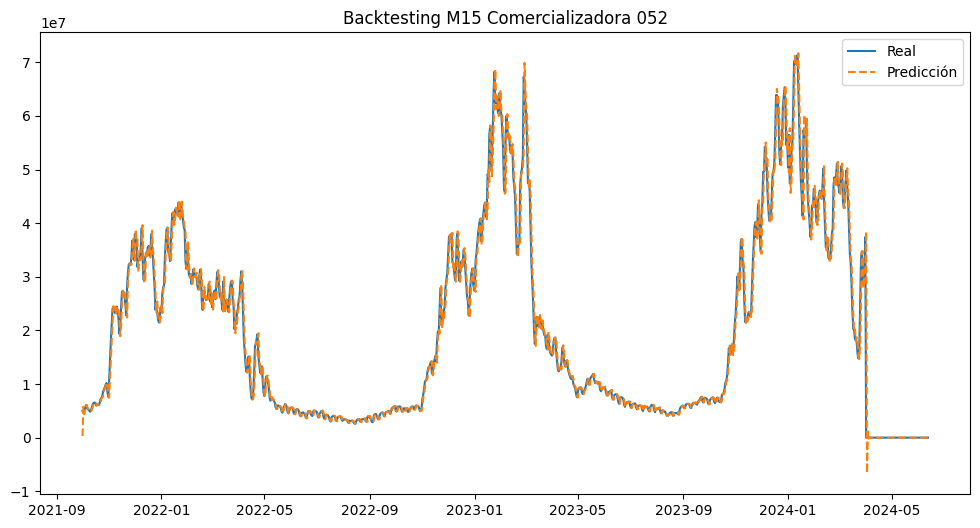

In [157]:
# Datos reales: Reparto_M15_052
reales_M15_052 = np.array(Reparto_M15_052)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_M15_052 = trace.posterior['beta_052_Temp_Max'].mean().item()
beta_temp_min_M15_052 = trace.posterior['beta_052_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_M15_052 = beta_temp_max_M15_052 * Temp_ponderada_Max_052 + beta_temp_min_M15_052 * Temp_ponderada_Min_052

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_M15_052 = reales_M15_052 - predicciones_bayes_M15_052

# Ajustar modelo ARIMA para el residual (noise)
model_M15_052_arima = ARIMA(noise_M15_052, order=(1,1,1))
model_M15_052_fit = model_M15_052_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_M15_052 = model_M15_052_fit.fittedvalues

# Predicción final combinada
predicciones_finales_M15_052 = predicciones_bayes_M15_052 + predicciones_arima_M15_052

# Calcular métricas de evaluación para el backtesting
mae_M15_052 = mean_absolute_error(reales_M15_052, predicciones_finales_M15_052)
rmse_M15_052 = np.sqrt(mean_squared_error(reales_M15_052, predicciones_finales_M15_052))

print(f"MAE M15_052: {mae_M15_052}")
print(f"RMSE M15_052: {rmse_M15_052}")

# Crear un DataFrame con los resultados
df_backtesting_M15_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_052), freq='D'),
    'Real': reales_M15_052,
    'Prediccion': predicciones_finales_M15_052
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_M15_052['Fecha'], df_backtesting_M15_052['Real'], label='Real')
plt.plot(df_backtesting_M15_052['Fecha'], df_backtesting_M15_052['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting M15 Comercializadora 052')
plt.legend()
plt.show()


In [158]:
# Crear un DataFrame con los resultados
df_backtesting_M15_052 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_M15_052), freq='D'),
    'Real': reales_M15_052,
    'Prediccion': predicciones_finales_M15_052
})
df_backtesting_M15_052.head(5)

,Fecha,Real,Prediccion
0,2021-10-01,4964015.0,2.888204e+05
1,2021-10-02,4590586.0,5.749521e+06
2,2021-10-03,4991559.0,4.367382e+06
3,2021-10-04,5544540.0,5.058275e+06
4,2021-10-05,6046824.0,5.668769e+06


MAE N1_762: 1893.300823770485
RMSE N1_762: 2619.8643208910066


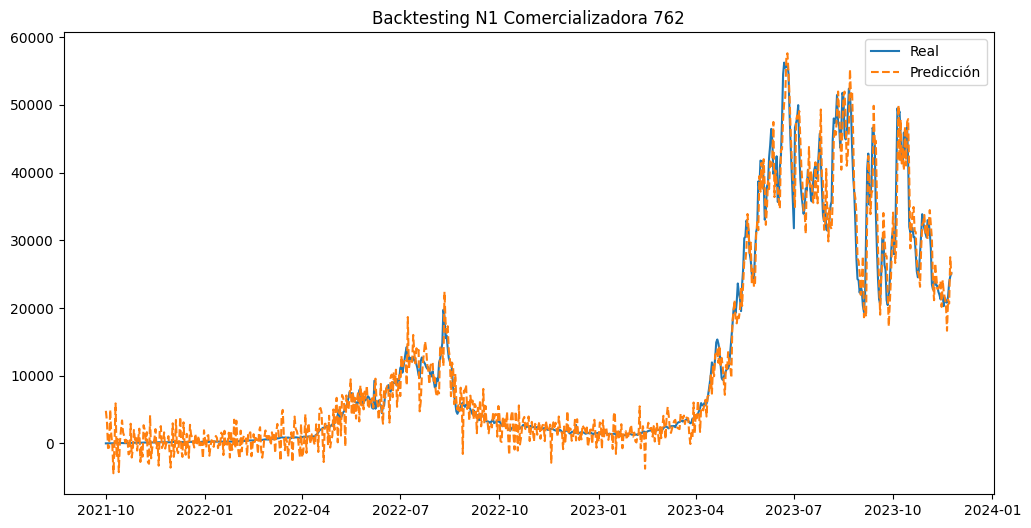

In [159]:
# Datos reales: Reparto_N1_762
reales_N1_762 = np.array(Reparto_N1_762)

# Extraer las medias de los coeficientes del posterior
beta_temp_max_N1_762 = trace.posterior['beta_762_Temp_Max'].mean().item()
beta_temp_min_N1_762 = trace.posterior['beta_762_Temp_Min'].mean().item()

# Realizar predicciones retrospectivas (backtesting)
predicciones_bayes_N1_762 = beta_temp_max_N1_762 * Temp_ponderada_Max_762 + beta_temp_min_N1_762 * Temp_ponderada_Min_762

# Calcular el residual (noise) entre datos reales y predicciones bayesianas
noise_N1_762 = reales_N1_762 - predicciones_bayes_N1_762

# Ajustar modelo ARIMA para el residual (noise)
model_N1_762_arima = ARIMA(noise_N1_762, order=(1,1,1))
model_N1_762_fit = model_N1_762_arima.fit()

# Hacer predicciones usando ARIMA sobre el residual
predicciones_arima_N1_762 = model_N1_762_fit.fittedvalues

# Predicción final combinada
predicciones_finales_N1_762 = predicciones_bayes_N1_762 + predicciones_arima_N1_762

# Calcular métricas de evaluación para el backtesting
mae_N1_762 = mean_absolute_error(reales_N1_762, predicciones_finales_N1_762)
rmse_N1_762 = np.sqrt(mean_squared_error(reales_N1_762, predicciones_finales_N1_762))

print(f"MAE N1_762: {mae_N1_762}")
print(f"RMSE N1_762: {rmse_N1_762}")

# Crear un DataFrame con los resultados
df_backtesting_N1_762 = pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_762), freq='D'),
    'Real': reales_N1_762,
    'Prediccion': predicciones_finales_N1_762
})

# Plotear los resultados del backtesting
plt.figure(figsize=(12, 6))
plt.plot(df_backtesting_N1_762['Fecha'], df_backtesting_N1_762['Real'], label='Real')
plt.plot(df_backtesting_N1_762['Fecha'], df_backtesting_N1_762['Prediccion'], label='Predicción', linestyle='--')
plt.title('Backtesting N1 Comercializadora 762')
plt.legend()
plt.show()


In [160]:
# Crear un DataFrame con los resultados
df_backtesting_N1_762= pd.DataFrame({
    'Fecha': pd.date_range(start='2021-10-01', periods=len(reales_N1_762), freq='D'),
    'Real': reales_N1_762,
    'Prediccion': predicciones_finales_N1_762
})
df_backtesting_N1_762.head(-5)

,Fecha,Real,Prediccion
0,2021-10-01,10.0,4817.136576
1,2021-10-02,11.0,3235.760101
2,2021-10-03,10.0,-682.462933
3,2021-10-04,16.0,-607.847533
4,2021-10-05,14.0,4989.911997
...,...,...,...
775,2023-11-15,22220.0,20159.944406
776,2023-11-16,21823.0,24083.478324
777,2023-11-17,20273.0,22301.021557
778,2023-11-18,21449.0,21508.298721
